<a href="https://colab.research.google.com/github/SamEhrlich/StuffModel6-24-24/blob/main/stuff_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All of these projects that have been done in the past helped me construct my own Stuff model  
[My previous Stuff Model in R 8/01/23](https://github.com/SamEhrlich/BaseballSavantShinyVisuals)  
[Nick Wans Stuff Model notebook](https://colab.research.google.com/drive/1L8b56-cKxbMLCJafA1qX9VVor6-HsyZd?usp=sharing#scrollTo=U9ZClmew1ArF )  
[Scott Powers presentation at Saberseminar 2023](https://github.com/saberpowers/talks/blob/master/2023/saberseminar/slides.pdf)  
[Fangraphs intro to Pitch modeling by Owen McGrattan](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/)   
[Driveline Baseball's first article detailing their pitch modeling](https://www.drivelinebaseball.com/2021/12/what-is-stuff-quantifying-pitches-with-pitch-models/ )   
[Driveline's Jack Lambert revisiting to original pitch modeling](https://www.drivelinebaseball.com/2024/05/revisiting-stuff-plus/)  
[Thomas Nestico's pitch modeling article](https://medium.com/@thomasjamesnestico/modelling-tjstuff-d9a451765484)  
[VAA Primer Fangraphs](https://blogs.fangraphs.com/a-visualized-primer-on-vertical-approach-angle-vaa/)  
[HAA Primer Fangraphs](https://blogs.fangraphs.com/a-visual-primer-on-horizontal-approach-angle-haa/)  
[Optuna XGBoost Parameter Tuning Kaggle Notebook by Hamza Ghanmi](https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna)


In [1]:
!pip install pybaseball
!pip install shap
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 47.1 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pybaseball as pbb
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn import cluster
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import IsolationForest
import shap
import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [3]:
#load all years without any data transformations yet
project_dir = 'drive/My Drive/Colab Notebooks'
df = pd.DataFrame()
df = pd.read_csv("{}/raw-all-years-data.csv".format(project_dir))

#load df with data for vaa already included
# project_dir = 'drive/My Drive/Colab Notebooks'
# df = pd.DataFrame()
# df = pd.read_csv("{}/all-data-vaa.csv".format(project_dir))

In [4]:
#data loading
project_dir = 'drive/My Drive/Colab Notebooks'
df = pd.DataFrame()

for year in range(2021,2024):
  df = pbb.statcast(start_dt="{}-03-01".format(year), end_dt="{}-12-01".format(year))
  # df.to_csv("{}/{}-data.csv".format(project_dir,year), index=False)

for year in range(2021,2024):
  _df = pd.read_csv('{}/{}-data.csv'.format(project_dir,year))
  print(_df.shape)
  df = pd.concat([df,_df])


In [5]:
df.shape

(2307866, 94)

In [6]:
df.columns.values

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estima

In [7]:
df['events'].unique()

array(['field_out', nan, 'single', 'strikeout', 'home_run', 'double',
       'walk', 'grounded_into_double_play', 'field_error', 'force_out',
       'sac_fly', 'hit_by_pitch', 'fielders_choice', 'triple',
       'fielders_choice_out', 'strikeout_double_play',
       'caught_stealing_2b', 'double_play', 'sac_bunt',
       'caught_stealing_home', 'other_out', 'pickoff_3b',
       'catcher_interf', 'sac_fly_double_play', 'caught_stealing_3b',
       'wild_pitch', 'passed_ball', 'stolen_base_2b', 'pickoff_2b',
       'pickoff_1b', 'sac_bunt_double_play', 'pickoff_caught_stealing_2b',
       'game_advisory', 'triple_play', 'pickoff_caught_stealing_3b',
       'pickoff_caught_stealing_home', 'stolen_base_3b',
       'pickoff_error_3b'], dtype=object)

In [8]:
#data cleaning and feature creation

#id swinging events
df['swing'] = 0
df.loc[df['description'].isin(['foul','strike_swinging','hit_into_play','foul_tip','swinging_strike_blocked']), 'swing'] = 1

#define a whiff
df['whiff'] = 0
df.loc[(df['swing'] == 1) & (df['description'].isin(['strike_swinging','swinging_strike_blocked','foul_tip'])), 'whiff'] = 1

#id hit events
df['hit'] = 0
df.loc[df['events'].isin(['single','double','triple','home_run']), 'hit'] = 1

#id home team team
df['p_team'] = df['away_team']
df.loc[(df['inning_topbot'] == 'Top'), 'p_team'] = df.loc[(df['inning_topbot'] == 'Top'), 'home_team']

#create year col
df['year'] = pd.to_datetime(df['game_date']).dt.year
df = df.reset_index(drop=True)

#create attack zones
df['attack_zone'] = 'waste'
df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833,3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.108, 1.108)) & (df['plate_z'].between(1.166,3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.666, 1.666)) & (df['plate_z'].between(0.5,4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

#mark handedness of batter and pitcher
df['is_lhb'] = 0
df.loc[df['stand'] == 'L', 'is_lhb'] = 1
df['is_lhp'] = 0
df.loc[df['p_throws'] == 'L', 'is_lhp'] = 1

#create spray angle
df['spray_angle'] = 0
df['spray_angle'] = round(np.arctan((df['hc_x'] - 125.42) / (198.27 - df['hc_y'])) * 180 / math.pi * 0.75, 1)

#get batter names using chadwick ids in pybaseball
df = df.rename(columns={'player_name':'pitcher_name'})
batter_bio = pbb.playerid_reverse_lookup(df['batter'].unique().tolist())
batter_bio['batter_name'] = batter_bio['name_last'].add(', ').add(batter_bio['name_first'])
df = df.merge(batter_bio.loc[:, ['key_mlbam','batter_name']].rename(columns={'key_mlbam':'batter'}), how='left')
df = df.rename(columns={'player_name':'pitcher_name'})
# df.to_csv("{}/all-years-data.csv".format(project_dir), index=False)


Gathering player lookup table. This may take a moment.


In [9]:
#orient left and right handed pitches to mirror each other
df['pfx_x_adj'] = df['pfx_x']
df['release_pos_x_adj'] = df['release_pos_x']
for col in ['pfx_x_adj', 'release_pos_x_adj']:
  df.loc[df['p_throws']=='L', col] = df.loc[df['p_throws']=='L', col].mul(-1)


In [10]:
# Define a color dictionary that maps to each pitch type
pitch_palette = dict(FF = "#EEE8AA", SI = "#00BFFF", SL = "#8B0000", CH = "#228B22",
          CU = "#FA8072", FC = "#D8BFD8", KC = "#F5DEB3", FS = "#006400", ST = "#ADD8E6", FA = "#D3D3D3",
          CS = "#FFFACD", EP = "#FF8C00", FO = "#A0522D", KN = "#FF00FF", SC = "#000080", PO = "#FF4500", SV = "#66CDAA")

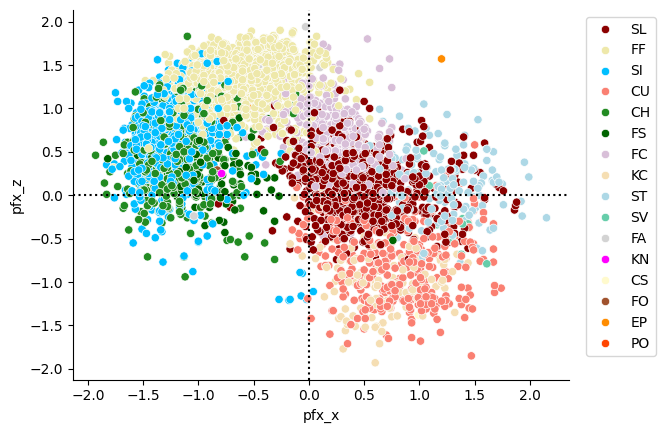

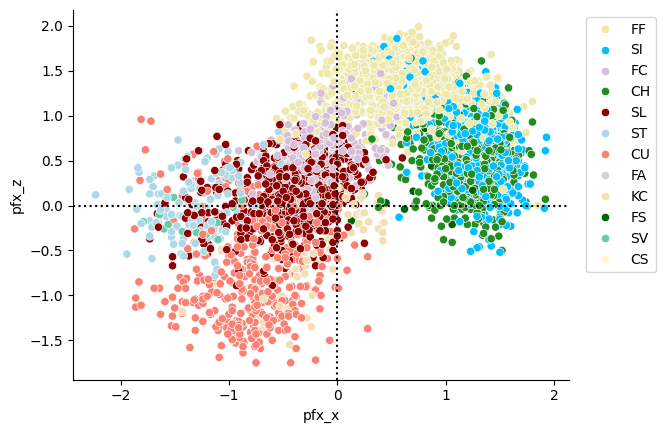

In [11]:
#movement plot for righty
sns.scatterplot(data=df.loc[df['p_throws'] == 'R'].sample(5000).reset_index(),
                x='pfx_x', y='pfx_z',hue = 'pitch_type',palette = pitch_palette)
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

#movement plot for lefty
sns.scatterplot(data=df.loc[df['p_throws'] == 'L'].sample(5000).reset_index(),
                x='pfx_x', y='pfx_z', hue = 'pitch_type',palette = pitch_palette)
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()


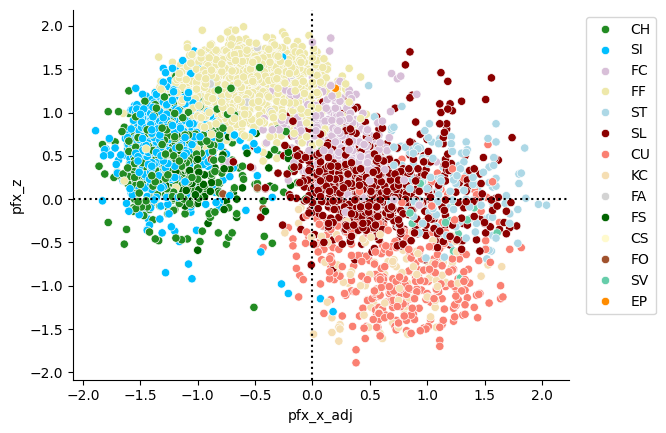

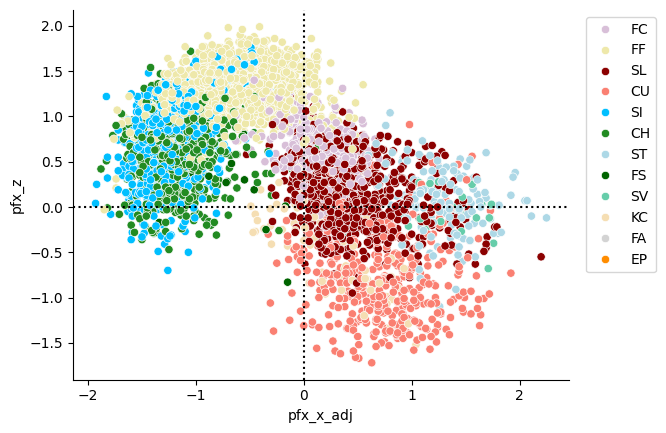

In [12]:
#movement plot with mirrored pitches
sns.scatterplot(data=df.loc[df['p_throws'] == 'R'].sample(5000).reset_index(),
                x='pfx_x_adj', y='pfx_z', hue = 'pitch_type',palette = pitch_palette)
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()


#movement plot with mirrored pitches
sns.scatterplot(data=df.loc[df['p_throws'] == 'L'].sample(5000).reset_index(),
                x='pfx_x_adj', y='pfx_z', hue = 'pitch_type',palette = pitch_palette)
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

In [13]:
#clustering to determine pitch families
id_feats = ['pitch_type','pitch_name']
cluster_data_feats = ['release_speed','pfx_x_adj','pfx_z','release_pos_x_adj','release_pos_z','release_extension','release_spin_rate','spin_axis']


cluster_data = df[id_feats + cluster_data_feats]


In [14]:
#for clustering i will only use the median of each pitch type to reduce the amount of data being calculated
cluster_data_summary = cluster_data.groupby(['pitch_type','pitch_name'], as_index=False).median()

#remove pitch out as a pitch type for this clustering
cluster_data_summary = cluster_data_summary.loc[~cluster_data_summary['pitch_type'].isin(['PO','FA'])]

cluster_data_summary

pitch_type       pitch_name  release_speed  pfx_x_adj  pfx_z  \
0          CH         Changeup          85.40     -1.210  0.530   
1          CS       Slow Curve          68.30      1.100 -1.080   
2          CU        Curveball          79.10      0.780 -0.850   
3          EP           Eephus          48.10     -0.200  1.410   
5          FC           Cutter          88.80      0.220  0.660   
6          FF  4-Seam Fastball          94.00     -0.630  1.360   
7          FO         Forkball          83.00     -0.600  0.110   
8          FS     Split-Finger          86.40     -0.960  0.290   
9          KC    Knuckle Curve          81.40      0.580 -0.880   
10         KN      Knuckleball          76.35     -0.250  0.035   
12         SC        Screwball          80.15     -0.865 -0.235   
13         SI           Sinker          93.30     -1.280  0.740   
14         SL           Slider          85.30      0.400  0.140   
15         ST          Sweeper          81.80      1.210  0.090   
16         SV           Slurve          82.40      1.250 -0.180   

    release_pos_x_adj  release_pos_z  release_extension  release_spin_rate  \
0              -1.890          5.790                6.4             1733.0   
1              -1.625          6.155                6.3             2300.5   
2              -1.690          6.000                6.3             2525.0   
3              -1.440          6.620                4.6             1167.0   
5              -1.820          5.890                6.3             2375.0   
6              -1.800          5.900                6.4             2281.0   
7              -1.880          5.970                6.4             1084.0   
8              -1.860          5.910                6.4             1397.0   
9              -1.760          5.950                6.4             2498.0   
10             -1.515          5.645                6.1              281.5   
12             -1.305          6.010                6.3             2092.0   
13             -1.890          5.740                6.4             2139.0   
14             -1.930          5.850                6.3             2403.0   
15             -2.120          5.520                6.4             2572.0   
16             -1.750          5.580                5.9             2601.5   

    spin_axis  
0       227.0  
1        40.0  
2        51.0  
3       206.0  
5       182.0  
6       206.0  
7       252.0  
8       233.0  
9        40.0  
10      176.5  
12      290.0  
13      215.0  
14      128.0  
15       69.0  
16       57.0

In [15]:
#map colors to each pitch type
cluster_data_summary['pitch_palette'] = cluster_data_summary['pitch_type'].map(pitch_palette)

In [16]:
#pitch type variable
pitch_types = cluster_data_summary['pitch_type'].unique()

cluster_data_summary_numeric = cluster_data_summary.drop(['pitch_type','pitch_name','pitch_palette'], axis=1)


In [17]:
#set k to 4 clusters to see the cluster pattern
K = 4

#create Hierarchical Clustering using ward linkage and euclidean distance
agglo = cluster.AgglomerativeClustering(metric='euclidean',
                                     linkage='ward',
                                     n_clusters=K)

#fit the average of all pitch types to their clusters
agglo = agglo.fit(cluster_data_summary_numeric)

#retrieve labels
labels = agglo.labels_

#assign the labels back to the pitch types
cluster_data_summary['labels'] = labels

In [18]:
#view the pitch names and cluster assignments
print(cluster_data_summary[['pitch_type','pitch_name','labels']])

   pitch_type       pitch_name  labels
0          CH         Changeup       0
1          CS       Slow Curve       1
2          CU        Curveball       3
3          EP           Eephus       0
5          FC           Cutter       1
6          FF  4-Seam Fastball       1
7          FO         Forkball       0
8          FS     Split-Finger       0
9          KC    Knuckle Curve       3
10         KN      Knuckleball       2
12         SC        Screwball       1
13         SI           Sinker       1
14         SL           Slider       1
15         ST          Sweeper       3
16         SV           Slurve       3


In [19]:
#function to create dendrogram from Hierarchical Clustering documentation
counts = np.zeros(agglo.children_.shape[0])
n_samples = len(agglo.labels_)
for i, merge in enumerate(agglo.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [agglo.children_, counts]
).astype(float)


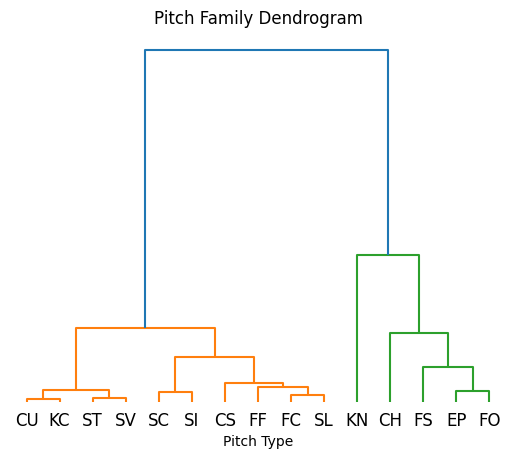

In [20]:
#plot dendrogram
dendrogram = sch.linkage(cluster_data_summary_numeric, method = 'ward')
sch.dendrogram(dendrogram, labels = pitch_types, orientation = 'top', distance_sort = True)
plt.title('Pitch Family Dendrogram')
plt.xlabel('Pitch Type')
plt.ylabel('')
plt.gca().yaxis.set_ticks([])
plt.gca().yaxis.set_ticklabels([])
sns.despine(left = True, bottom = True)
plt.show()

# # another variation with the y axis visible
# dendrogram = sch.linkage(cluster_data_summary_numeric, method = 'ward')
# sch.dendrogram(dendrogram, labels = pitch_types, orientation = 'top', distance_sort = True)
# plt.title('Pitch Family Dendrogram')
# plt.xlabel('Pitch Type')
# plt.ylabel('Distance')
# sns.despine()
# plt.show()


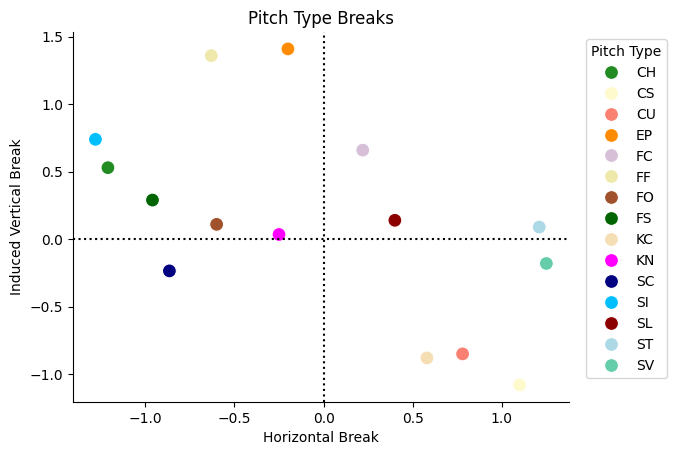

In [21]:
#plot the movement profile of the average for each pitch type
sns.scatterplot(data=cluster_data_summary,
                x='pfx_x_adj', y='pfx_z', hue = 'pitch_type', palette = pitch_palette,
                s = 100)
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title = 'Pitch Type')
plt.title('Pitch Type Breaks')
plt.xlabel('Horizontal Break')
plt.ylabel('Induced Vertical Break')
sns.despine()
plt.show()


In [22]:
#view cluster assignments

for clust in range(0,4):
   print(cluster_data_summary[['pitch_type','pitch_name','labels']].loc[cluster_data_summary['labels'] == clust])

  pitch_type    pitch_name  labels
0         CH      Changeup       0
3         EP        Eephus       0
7         FO      Forkball       0
8         FS  Split-Finger       0
   pitch_type       pitch_name  labels
1          CS       Slow Curve       1
5          FC           Cutter       1
6          FF  4-Seam Fastball       1
12         SC        Screwball       1
13         SI           Sinker       1
14         SL           Slider       1
   pitch_type   pitch_name  labels
10         KN  Knuckleball       2
   pitch_type     pitch_name  labels
2          CU      Curveball       3
9          KC  Knuckle Curve       3
15         ST        Sweeper       3
16         SV         Slurve       3


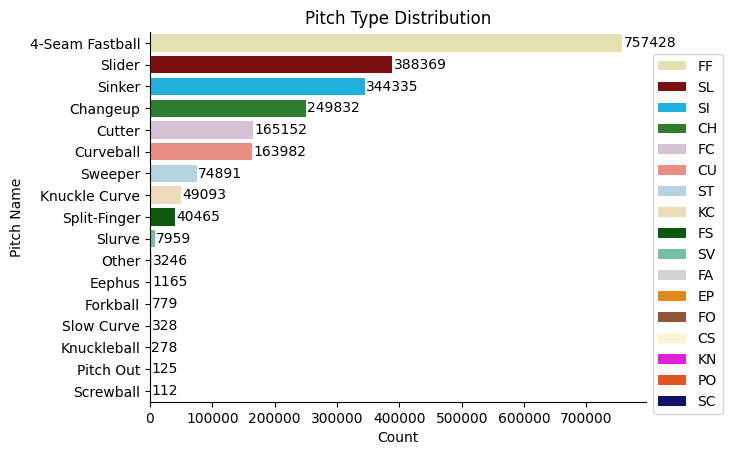

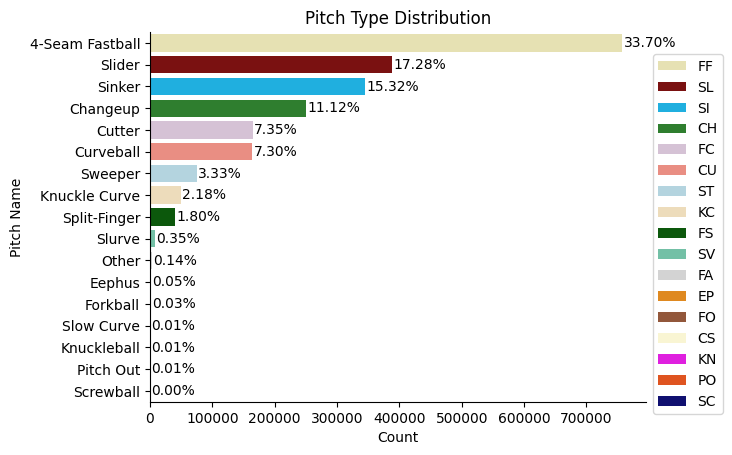

In [23]:
#see how many pitches of each type were thrown
pitch_type_counts = df[['pitch_type','pitch_name']].value_counts().reset_index(name='counts')

#pitch type distribution plot with counts as labels
sns.barplot(data=pitch_type_counts, x='counts', y='pitch_name', hue='pitch_type', palette= pitch_palette)
plt.legend(bbox_to_anchor=(1,.96), loc=2)
plt.title('Pitch Type Distribution')
plt.xlabel('Count')
plt.ylabel('Pitch Name')

#loop through the coordinates of each bar to assign labels
for container in plt.gca().containers:
  plt.gca().bar_label(container, label_type='edge', padding=1)

sns.despine()
plt.show()


total_count = pitch_type_counts['counts'].sum()

#same plot with % share of total pitches
sns.barplot(data=pitch_type_counts, x='counts', y='pitch_name', hue='pitch_type', palette= pitch_palette)
plt.legend(bbox_to_anchor=(1,.96), loc=2)
plt.title('Pitch Type Distribution')
plt.xlabel('Count')
plt.ylabel('Pitch Name')

#loop through the coordinates of each bar
for container in plt.gca().containers:
  #get the length of each bar (width) and divide by total pitch count to get percent of pitches thrown by each type
  labels = [f'{(v.get_width() / total_count) * 100:.2f}%' for v in container]
  #apply labels stored above
  plt.gca().bar_label(container, labels = labels, label_type='edge', padding=1)

sns.despine()
plt.show()


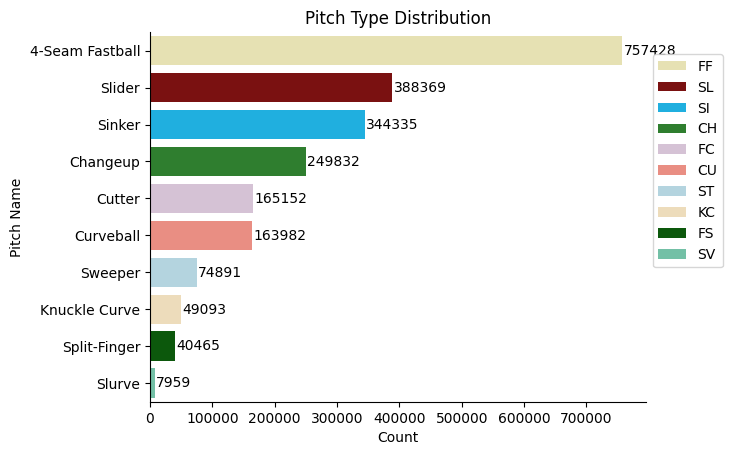

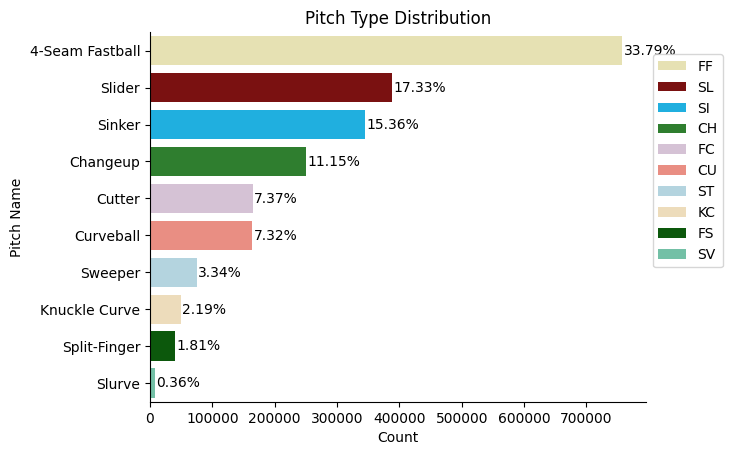

In [24]:
#cut out all pitches thrown from other and below
pitches_to_remove = ['Other','Eephus','Forkball','Slow Curve','Knuckleball','Pitch Out','Screwball']
df_frequent_pitches = df.loc[~df['pitch_name'].isin(pitches_to_remove)]

#grab the counts
pitch_type_counts = df_frequent_pitches[['pitch_type','pitch_name']].value_counts().reset_index(name='counts')

total_count = pitch_type_counts['counts'].sum()

sns.barplot(data=pitch_type_counts, x='counts', y='pitch_name', hue='pitch_type', palette= pitch_palette)
plt.legend(bbox_to_anchor=(1,.96), loc=2)
plt.title('Pitch Type Distribution')
plt.xlabel('Count')
plt.ylabel('Pitch Name')

# loop through the coordinates of each bar to assign labels
for container in plt.gca().containers:
  plt.gca().bar_label(container, label_type='edge', padding=1)

sns.despine()
plt.show()

#one more with percents for easier viewing
sns.barplot(data=pitch_type_counts, x='counts', y='pitch_name', hue='pitch_type', palette= pitch_palette)
plt.legend(bbox_to_anchor=(1,.96), loc=2)
plt.title('Pitch Type Distribution')
plt.xlabel('Count')
plt.ylabel('Pitch Name')

#loop through the coordinates of each bar
for container in plt.gca().containers:
  #get the length of each bar (width) and divide by total pitch count to get percent of pitches thrown by each type
  labels = [f'{(v.get_width() / total_count) * 100:.2f}%' for v in container]
  #apply labels stored above
  plt.gca().bar_label(container, labels = labels, label_type='edge', padding=1)

sns.despine()
plt.show()


In [25]:
#clustering to determine pitch families with shrunk dataset

id_feats = ['year','pitcher', 'pitcher_name', 'pitch_type','pitch_name']
id_feats = ['pitch_type','pitch_name']
cluster_data_feats = ['release_speed','pfx_x_adj','pfx_z','release_pos_x_adj','release_pos_z','release_extension','release_spin_rate','spin_axis']

cluster_data = df[id_feats + cluster_data_feats]

#for clustering i will only use the median of each pitch type to reduce the amount of data being calculated
cluster_data_summary = cluster_data.groupby(['pitch_type','pitch_name'], as_index=False).median()

#remove pitch out as a pitch type for this clustering
cluster_data_summary = cluster_data_summary.loc[~cluster_data_summary['pitch_name'].isin(pitches_to_remove)]

cluster_data_summary

#potentially scale the cluster data before running hclust

pitch_types = cluster_data_summary['pitch_type'].unique()

#map colors to each pitch type
cluster_data_summary['pitch_palette'] = cluster_data_summary['pitch_type'].map(pitch_palette)

cluster_data_summary_numeric = cluster_data_summary.drop(['pitch_type','pitch_name','pitch_palette'], axis=1)

#set k to 4 clusters to see the cluster pattern
K = 3

#create Hierarchical Clustering using ward linkage and euclidean distance
agglo = cluster.AgglomerativeClustering(metric='euclidean',
                                     linkage='ward',
                                     n_clusters=K)

#fit the average of all pitch types to their clusters
agglo = agglo.fit(cluster_data_summary_numeric)

#retrieve labels
labels = agglo.labels_

#assign the labels back to the pitch types
cluster_data_summary['labels'] = labels

#view the pitch names and cluster assignments
cluster_data_summary[['pitch_type','pitch_name','labels']]

pitch_type       pitch_name  labels
0          CH         Changeup       0
2          CU        Curveball       2
5          FC           Cutter       1
6          FF  4-Seam Fastball       1
8          FS     Split-Finger       0
9          KC    Knuckle Curve       2
13         SI           Sinker       1
14         SL           Slider       1
15         ST          Sweeper       2
16         SV           Slurve       2

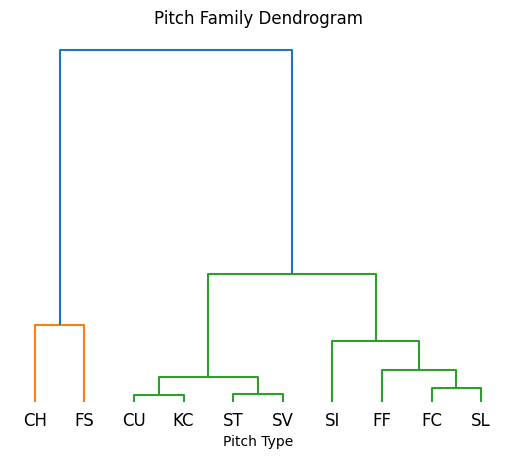

In [26]:
#check pitch family clustering with shrunk dataset

#plot dendrogram
dendrogram = sch.linkage(cluster_data_summary_numeric, method = 'ward')
sch.dendrogram(dendrogram, labels = pitch_types, orientation = 'top', distance_sort = True)
plt.title('Pitch Family Dendrogram')
plt.xlabel('Pitch Type')
plt.ylabel('')
plt.gca().yaxis.set_ticks([])
plt.gca().yaxis.set_ticklabels([])
sns.despine(left = True, bottom = True)
plt.show()


In [27]:
#create pitch families using cluster assignments, domain knowledge, and Driveline's specified pitch buckets

#fastball sinker are the 2 fastball type pitches
#cutter slider are similar to the fastballs but fall more in the sweeping movement like sweeper and slurve
#curve and knuckle curve are curveballs (could also count slow curves but only 328 in entire dataset)
#changeup and split finger are offspeed pitches used as a mixup from the traditional fastball
#everything else with low sample size will be classified under other or offspeeds that are not thrown often (forkballs, screwballs, knuckleballs)

df['pitch_family'] = 'Other'
df.loc[df['pitch_type'].isin(['FF','SI']), 'pitch_family'] = 'Fastball'
df.loc[df['pitch_type'].isin(['SL','ST','FC','SV']), 'pitch_family'] = 'Slider'
df.loc[df['pitch_type'].isin(['CU','KC']), 'pitch_family'] = 'Curveball'
df.loc[df['pitch_type'].isin(['CH','FS']), 'pitch_family'] = 'Offspeed'

#create a classifier version of pitch family for boosted models
df['pitch_family_code'] = df['pitch_family'].astype('category').cat.codes


In [28]:
#feature engineering additional features - primary pitches, velo diff, ssw, vert app angle and horz app angle adjustments

#find primary pitch - broken down by batter handedness
#a pitcher may throw more fastballs/cutters depending on batter handedness

#group by pitcherid, is_lhb, and pitch type to get the total count of each pitch thrown by pitch type
df_pitch_count_by_hand_type = df[['pitcher','pitch_type','is_lhb']].groupby(['pitcher','pitch_type','is_lhb'], as_index = False).value_counts().rename(columns={'count':'pitch_count_by_type_hand'})

#group by pitcherid, is_lhb to get the total pitches thrown by handedness
df_pitch_count_by_hand = df_pitch_count_by_hand_type[['pitcher','is_lhb','pitch_count_by_type_hand']].groupby(['pitcher','is_lhb'], as_index = False).sum().rename(columns={'pitch_count_by_type_hand':'pitch_count_by_hand'})

#merge the count dfs
df_primary_pitch_breakdown = pd.merge(df_pitch_count_by_hand_type,df_pitch_count_by_hand, on = ['pitcher','is_lhb'])

#create the percentage of each pitch type thrown column by dividing the count of each by total count
df_primary_pitch_breakdown['pitch_freq_pct_by_hand'] = df_primary_pitch_breakdown['pitch_count_by_type_hand'] / df_primary_pitch_breakdown['pitch_count_by_hand'] * 100

df_primary_pitch_breakdown.head(20)

#identify primary pitch - either 4 seam, sinker, cutter for each pitcher based on the handedness of the batter they are facing
df_primary_pitch_breakdown['primary_pitch_by_hand'] = 0
primary_pitch_types = df_primary_pitch_breakdown.loc[(df_primary_pitch_breakdown['pitch_type'].isin(['FF','SI','FC']))]

#identify the index where the pitch is the highest frequency
primary_idx = primary_pitch_types.loc[primary_pitch_types.groupby(['pitcher','is_lhb'])['pitch_freq_pct_by_hand'].idxmax()]

primary_idx = primary_idx.index

df_primary_pitch_breakdown.loc[primary_idx, 'primary_pitch_by_hand'] = 1


In [29]:
#check to see the counts of all pitchers individual pitches and make sure they have 2 primary pitch types (1 for each hand)

pitch_breakdown_summary = df_primary_pitch_breakdown.groupby(['pitcher'], as_index = False).sum()

#all pitchers that do not have a primary pitch being a fastball, sinker, or cutter for both hands
pitch_breakdown_summary[['pitcher','pitch_count_by_type_hand','pitch_count_by_hand','primary_pitch_by_hand']].loc[(pitch_breakdown_summary['primary_pitch_by_hand'] != 2)]



pitcher  pitch_count_by_type_hand  pitch_count_by_hand  \
0      405395                        27                   54   
12     444482                        28                   28   
13     444876                        24                   72   
27     452678                        17                   21   
37     455117                        30                   60   
...       ...                       ...                  ...   
1649   689379                         8                   16   
1675   696275                        13                   39   
1689   701803                         3                    6   
1691   702795                        11                   33   
1696   802408                        13                   39   

      primary_pitch_by_hand  
0                         0  
12                        0  
13                        0  
27                        0  
37                        0  
...                     ...  
1649                      1  
1675                      1  
1689                      1  
1691                      1  
1696                      1  

[227 rows x 4 columns]

In [30]:
#take a look at those individual pitchers and assess if they are worth keeping in the model as competitve pitchers

missing_primary_pitch = pitch_breakdown_summary[['pitcher','pitch_count_by_type_hand','pitch_count_by_hand','primary_pitch_by_hand']].loc[(pitch_breakdown_summary['primary_pitch_by_hand'] != 2)]
missing_primary_pitch_list = missing_primary_pitch['pitcher']
missing_primary_pitch_df = df.loc[(df['pitcher']).isin(missing_primary_pitch_list)]

#the largest amount of pitches thrown in these groups are not even pitchers - safe to remove these player's pitches from the model
missing_primary_pitch.sort_values('pitch_count_by_hand', ascending = False)
df.loc[((df['pitcher'] == 670097))]


pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
1690161         FA  2023-08-27           70.0          -1.14           6.51   
1690162         FA  2023-08-27           72.6          -1.46           6.36   
1690163         FA  2023-08-27           75.3          -1.46           6.38   
1690164         FA  2023-08-27           69.1          -1.42           6.19   
1690165         FA  2023-08-27           72.1          -1.50           6.34   
...            ...         ...            ...            ...            ...   
2040361         EP  2023-05-26           42.1          -0.96           7.07   
2040362         EP  2023-05-26           40.7          -1.07           7.12   
2040363         EP  2023-05-26           42.8          -0.98           7.22   
2040364         EP  2023-05-26           41.2          -1.13           7.03   
2040365         EP  2023-05-26           42.9          -1.28           7.07   

        pitcher_name  batter  pitcher     events    description  ...  year  \
1690161  Short, Zack  676694   670097  field_out  hit_into_play  ...  2023   
1690162  Short, Zack  670541   670097     double  hit_into_play  ...  2023   
1690163  Short, Zack  670541   670097        NaN           ball  ...  2023   
1690164  Short, Zack  670541   670097        NaN           ball  ...  2023   
1690165  Short, Zack  670541   670097        NaN           foul  ...  2023   
...              ...     ...      ...        ...            ...  ...   ...   
2040361  Short, Zack  640449   670097     single  hit_into_play  ...  2023   
2040362  Short, Zack  640449   670097        NaN           ball  ...  2023   
2040363  Short, Zack  669394   670097     single  hit_into_play  ...  2023   
2040364  Short, Zack  518735   670097  field_out  hit_into_play  ...  2023   
2040365  Short, Zack  518735   670097        NaN  called_strike  ...  2023   

         attack_zone  is_lhb  is_lhp  spray_angle       batter_name pfx_x_adj  \
1690161        heart       0       0          3.0      meyers, jake     -0.44   
1690162        heart       1       0         34.6   álvarez, yordan     -0.60   
1690163        chase       1       0          NaN   álvarez, yordan     -0.49   
1690164        chase       1       0          NaN   álvarez, yordan     -0.77   
1690165        chase       1       0          NaN   álvarez, yordan     -0.64   
...              ...     ...     ...          ...               ...       ...   
2040361       shadow       0       0         12.8    frazier, clint      0.00   
2040362        waste       0       0          NaN    frazier, clint      0.01   
2040363       shadow       0       0        -12.0      burger, jake      1.67   
2040364       shadow       1       0         19.2  grandal, yasmani     -0.02   
2040365       shadow       1       0          NaN  grandal, yasmani     -0.07   

        release_pos_x_adj pitch_family pitch_family_code  
1690161             -1.14        Other                 3  
1690162             -1.46        Other                 3  
1690163             -1.46        Other                 3  
1690164             -1.42        Other                 3  
1690165             -1.50        Other                 3  
...                   ...          ...               ...  
2040361             -0.96        Other                 3  
2040362             -1.07        Other                 3  
2040363             -0.98        Other                 3  
2040364             -1.13        Other                 3  
2040365             -1.28        Other                 3  

[100 rows x 108 columns]

In [31]:
#filter out the pitchers without primary pitches
df = df.loc[~(df['pitcher']).isin(missing_primary_pitch_list)]

#also filter out of the primary pitch breakdown df
df_primary_pitch_breakdown = df_primary_pitch_breakdown.loc[~(df_primary_pitch_breakdown['pitcher'].isin(missing_primary_pitch))]

#join the breakdown summary to the original df
df = pd.merge(df,df_primary_pitch_breakdown, on = ['pitcher','pitch_type','is_lhb'])

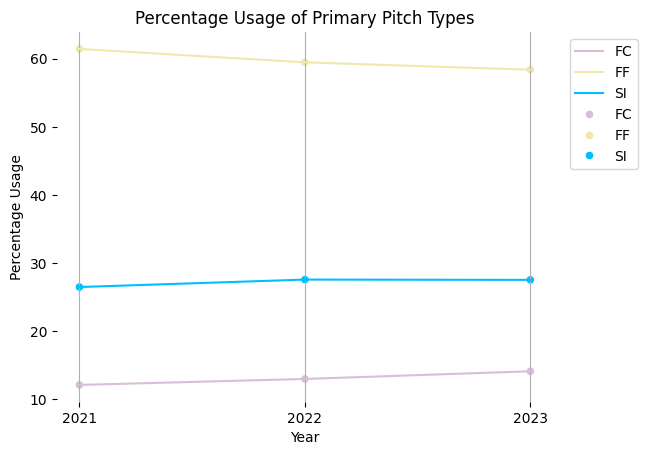

In [32]:
#percentage usage of each primary pitch by year
primary_pitch_list = ['FF','FC','SI']
primary_pitches_by_year_summary = pd.DataFrame(df[['game_year','pitch_type']].loc[(df['pitch_type'].isin(primary_pitch_list))].groupby(['game_year','pitch_type']).value_counts().reset_index())
total_pitches_by_year = primary_pitches_by_year_summary[['game_year','count']].groupby('game_year').sum().reset_index().rename(columns= {'count':'total'})
primary_pitches_by_year_summary = pd.merge(primary_pitches_by_year_summary,total_pitches_by_year, on = ['game_year'])
primary_pitches_by_year_summary['percentage_usage'] = primary_pitches_by_year_summary['count'] / primary_pitches_by_year_summary['total'] * 100

#lineplot
sns.lineplot(data = primary_pitches_by_year_summary, x = 'game_year', y = 'percentage_usage', hue = 'pitch_type', palette = pitch_palette)
sns.scatterplot(data = primary_pitches_by_year_summary, x = 'game_year', y = 'percentage_usage', hue = 'pitch_type', palette = pitch_palette)
plt.xticks(ticks = [2021, 2022, 2023],labels = ['2021','2022','2023'])
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.title('Percentage Usage of Primary Pitch Types')
plt.xlabel('Year')
plt.ylabel('Percentage Usage')
sns.despine(left = True, bottom = True)
plt.grid(axis = 'x')
plt.show()

In [33]:
#primary pitch breakdown charts
nola = df.loc[(df['pitcher'] == 605400) & (df['pitch_type'].isin(['FF','SI','FC']))]

#create separate dfs for each handedness
nola_lhh = nola.loc[(nola['is_lhb'] == 1)]
nola_rhh = nola.loc[(nola['is_lhb'] == 0)]

#get values for pie chart
pitch_type_counts_lhh = nola_lhh['pitch_type'].value_counts().reset_index()
pitch_type_counts_rhh = nola_rhh['pitch_type'].value_counts().reset_index()

#grab colors to match plots above and reorder to plot in order without mapping
pie_plot_palette = {k: v for k, v in pitch_palette.items() if k in primary_pitch_list}
desired_order_list = ['FF', 'FC', 'SI']
pie_plot_palette = {k: pie_plot_palette[k] for k in desired_order_list}

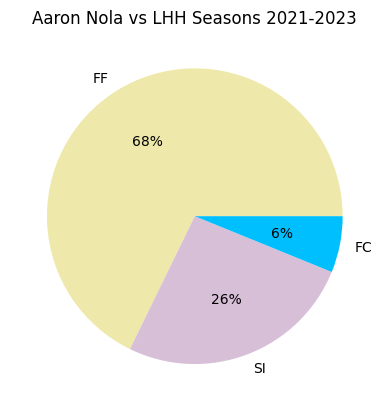

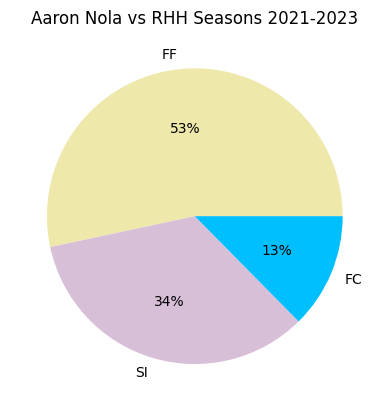

In [34]:
#aaron nola primary pitch breakdown by handedness from seasons 2021 - 2023

# nola vs lhh
plt.pie(x = pitch_type_counts_lhh['count'], labels = pitch_type_counts_lhh['pitch_type'], colors = pie_plot_palette.values(), autopct='%.0f%%')
plt.title('Aaron Nola vs LHH Seasons 2021-2023')
plt.show()

# nola vs rhh
plt.pie(x = pitch_type_counts_rhh['count'], labels = pitch_type_counts_rhh['pitch_type'], colors = pie_plot_palette.values(), autopct='%.0f%%')
plt.title('Aaron Nola vs RHH Seasons 2021-2023')
plt.show()

In [35]:
#take identified primary pitches and get the velo diff between their primary pitch and their other pitches

#get the average velo and movement for each player and year by batter handedness
df_avg_stats = df.loc[df['primary_pitch_by_hand']==1, ['game_year','pitcher','is_lhb','release_speed','pfx_x_adj','pfx_z']].groupby(['game_year','pitcher','is_lhb'],as_index=False).mean().rename(columns={'release_speed':'release_speed_avg','pfx_x_adj':'pfx_x_adj_avg','pfx_z':'pfx_z_avg'})
df = pd.merge(df, df_avg_stats, on = ['game_year','pitcher','is_lhb'])

#loop through speed and movement profiles and get the difference between their avg primary pitch and their other pitches
for col in ['release_speed','pfx_x_adj','pfx_z']:
  df["{}_diff".format(col)] = df[col].sub(df["{}_avg".format(col)])


In [36]:
#create vertical approach angle feature VAA
df_vaa = df.copy()
df_vaa['vy_f'] = -np.sqrt(df_vaa['vy0']**2 - 2 * df_vaa['ay'] * (50 - 17/12))
df_vaa['t'] = (df_vaa['vy_f'] - df_vaa['vy0']) / df_vaa['ay']
df_vaa['vz_f'] = df_vaa['vz0'] + (df_vaa['az'] * df_vaa['t'])
df_vaa['vaa'] = -np.arctan(df_vaa['vz_f']/df_vaa['vy_f']) * (180 / np.pi)

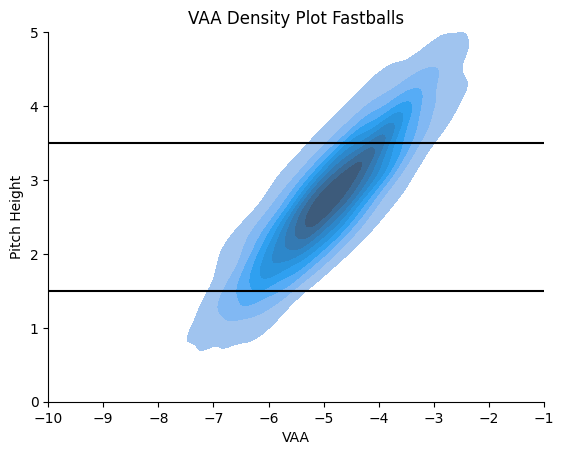

In [37]:
#VAA for fastballs density plot
sns.kdeplot(df_vaa.loc[df_vaa['pitch_type'] == 'FF'].sample(5000), x = 'vaa', y = 'plate_z', fill = True)
plt.xlabel('VAA')
plt.ylabel('Pitch Height')
plt.title('VAA Density Plot Fastballs')
plt.axhline(1.5,c='k')
plt.axhline(3.5,c='k')
plt.xlim(-10,-1)
plt.ylim(0,5)
sns.despine()
plt.show()

In [38]:
#creating heatmap using scatterplot grouping by density of delta run expectancy
heatmap_df_ff = df_vaa.loc[df_vaa['pitch_type'] == 'FF', ['pitch_type','vaa', 'plate_z', 'delta_run_exp']].copy()

#round the data to nearest .1
for col in ['vaa', 'plate_z']:
  heatmap_df_ff[col] = heatmap_df_ff[col].round(1)

#get a total delta run exp for each interval of vaa and plate_z
heatmap_df_ff = heatmap_df_ff[['vaa','plate_z','delta_run_exp']].groupby(['vaa', 'plate_z'], as_index=False).sum()

#pivot the heatmap by vaa to get a matrix representing the density for each point on the plot
heatmap_matrix_ff = pd.pivot_table(heatmap_df_ff, values='delta_run_exp', index='plate_z', columns='vaa')
#fill all empty cells with 0 as they will be worth 0 run exp on the plot
heatmap_matrix_ff = heatmap_matrix_ff.fillna(0)


# #apply guassian filtering to smooth the matrix
heatmap_temp_ff = gaussian_filter(heatmap_matrix_ff, sigma=.75)
# #transform the array back into df
heatmap_temp_ff = pd.DataFrame(heatmap_temp_ff, index=heatmap_matrix_ff.index, columns=heatmap_matrix_ff.columns)
heatmap_temp_ff = heatmap_temp_ff.reset_index()
# #melt columns from wide to long
df_temp_ff = pd.melt(heatmap_temp_ff, id_vars='plate_z', value_name='delta_run_exp')
# #merge values back to original df
heatmap_df_ff = df_temp_ff.merge(heatmap_df_ff.loc[:, ['vaa', 'plate_z']])

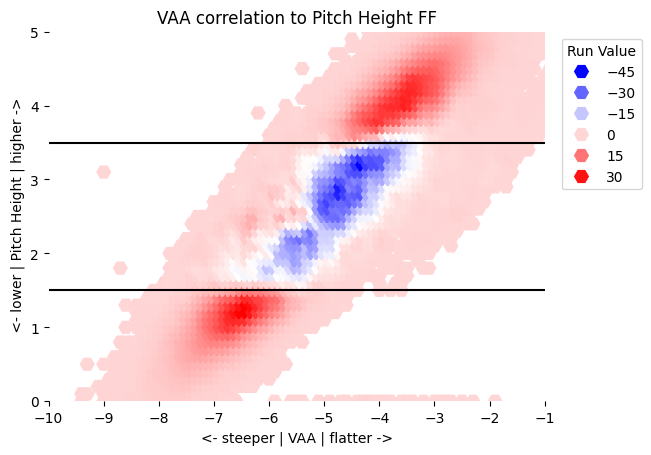

In [39]:
#plot the heatmap
sns.scatterplot(data=heatmap_df_ff, x='vaa', y='plate_z',
                hue='delta_run_exp', palette='bwr',
                edgecolor='none', marker='H', s=120)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title = 'Run Value')
plt.axhline(1.5,c='k')
plt.axhline(3.5,c='k')
plt.xlim(-10,-1)
plt.ylim(0,5)
plt.title('VAA correlation to Pitch Height FF')
plt.xlabel('<- steeper | VAA | flatter ->')
plt.ylabel(' <- lower | Pitch Height | higher ->')
sns.despine(left = True, bottom = True)
plt.show()

In [40]:
#normalize VAA by pitch height and type of pitch
df_vaaa = df_vaa.loc[:, ['game_year','pitcher','pitch_type','vaa', 'plate_z', 'delta_run_exp', 'whiff', 'swing']].copy()

#round the data to nearest .1
df_vaaa['plate_z_bin'] = df_vaaa['plate_z'].round(1)

#average vaa for each pitch height
df_vaaa_summary = df_vaaa.loc[:,['pitch_type','plate_z_bin','vaa']].groupby(['pitch_type','plate_z_bin'],as_index = False).mean().rename(columns = {'vaa':'vaa_avg'})
df_vaaa = pd.merge(df_vaaa, df_vaaa_summary, on = ['pitch_type','plate_z_bin'])

# take vaa and get the difference between the avg vaa and the vaa of each pitch
df_vaaa["vaaa"] = df_vaaa['vaa'].sub(df_vaaa["vaa_avg"])

# average of each pitch type should be normalized where the mean is 0
print(round(df_vaaa['vaaa'].loc[df_vaaa['pitch_type'] == 'CH'].dropna().mean(),3))


0.0


In [41]:
#creating heatmap using scatterplot grouping by density of delta run expectancy for
df_vaaa_ff = df_vaaa.loc[df_vaaa['pitch_type'] == 'FF', ['pitch_type','vaaa', 'plate_z', 'delta_run_exp']].copy()

#round the data to nearest .1
for col in ['vaaa', 'plate_z']:
  df_vaaa_ff[col] = df_vaaa_ff[col].round(1)

#get a total delta run exp for each interval of vaa and plate_z
df_vaaa_ff = df_vaaa_ff.groupby(['vaaa', 'plate_z'], as_index=False).sum()

#pivot the heatmap by vaa to get a matrix representing the density for each point on the plot
heatmap_matrix_vaaa = pd.pivot_table(df_vaaa_ff, values='delta_run_exp', index='plate_z', columns='vaaa')
#fill all empty cells with 0 as they will be worth 0 run exp on the plot
heatmap_matrix_vaaa = heatmap_matrix_vaaa.fillna(0)
#apply guassian filtering to smooth the matrix
heatmap_temp_vaaa = gaussian_filter(heatmap_matrix_vaaa, sigma=.50)
#transform the array back into df
heatmap_temp_vaaa = pd.DataFrame(heatmap_temp_vaaa, index=heatmap_matrix_vaaa.index, columns=heatmap_matrix_vaaa.columns)
heatmap_temp_vaaa = heatmap_temp_vaaa.reset_index()
#melt columns from wide to long
df_temp_vaa = pd.melt(heatmap_temp_vaaa, id_vars='plate_z', value_name='delta_run_exp')
#merge values back to original df
df_vaaa_ff = df_temp_vaa.merge(df_vaaa_ff.loc[:, ['vaaa', 'plate_z']])

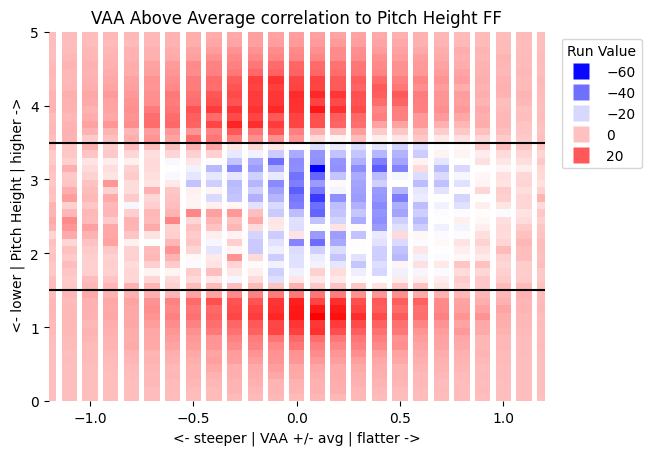

In [42]:
#plot the heatmap
sns.scatterplot(data=df_vaaa_ff, x='vaaa', y='plate_z',
                hue='delta_run_exp', palette='bwr',
                edgecolor='none', marker='s', s=120)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title = 'Run Value')
plt.axhline(1.5,c='k')
plt.axhline(3.5,c='k')
plt.xlim(-1.2,1.2)
plt.ylim(0,5)
plt.title('VAA Above Average correlation to Pitch Height FF')
plt.xlabel('<- steeper | VAA +/- avg | flatter ->')
plt.ylabel(' <- lower | Pitch Height | higher ->')
sns.despine(left = True, bottom = True)
plt.show()

In [43]:
#get whiff rate by loc
df_whiffs = df_vaa.loc[:, ['game_year','pitcher','pitch_type','vaa', 'plate_z','swing','whiff']].copy()

#round the data to nearest .1
df_whiffs['plate_z_bin'] = df_whiffs['plate_z'].round(1)

#average vaa for each pitch height
df_whiffs_summary = df_whiffs.loc[:,['pitch_type','plate_z_bin','swing','whiff']].groupby(['pitch_type','plate_z_bin'],as_index = False).sum().rename(columns = {'swing':'swing_tot','whiff':'whiff_tot'})
df_whiffs = pd.merge(df_whiffs, df_whiffs_summary, on = ['pitch_type','plate_z_bin'])

# take total whiffs and divide by total swings to get whiff rate
df_whiffs["whiff_pct"] = df_whiffs['whiff_tot'].div(df_whiffs["swing_tot"]) * 100

df_whiffs = df_whiffs.fillna(0)


In [44]:
#creating heatmap using scatterplot grouping by density of whiff pct
df_whiffs_ff = df_whiffs.loc[df_whiffs['pitch_type'] == 'FF', ['pitch_type','vaa', 'plate_z','whiff_pct']].copy()

#round the data to nearest .1
for col in ['vaa', 'plate_z']:
  df_whiffs_ff[col] = df_whiffs_ff[col].round(1)

#get an avg whiff rate for each interval of vaa and plate_z
df_whiffs_ff = df_whiffs_ff.groupby(['pitch_type','vaa', 'plate_z'], as_index=False).mean()

#pivot the heatmap by vaa to get a matrix representing the density for each point on the plot
heatmap_matrix_whiffs = pd.pivot_table(df_whiffs_ff, values='whiff_pct', index='plate_z', columns='vaa')
#fill all empty cells with 0 as they will have 0 % whiff rate in plot
heatmap_matrix_whiffs = heatmap_matrix_whiffs.fillna(0)
#apply guassian filtering to smooth the matrix
heatmap_temp_whiffs = gaussian_filter(heatmap_matrix_whiffs, sigma=.50)
#transform the array back into df
heatmap_temp_whiffs = pd.DataFrame(heatmap_temp_whiffs, index=heatmap_matrix_whiffs.index, columns=heatmap_matrix_whiffs.columns)
heatmap_temp_whiffs = heatmap_temp_whiffs.reset_index()
#melt columns from wide to long
df_temp_whiffs = pd.melt(heatmap_temp_whiffs, id_vars='plate_z', value_name='whiff_pct')
#merge values back to original df
df_whiffs_ff = df_temp_whiffs.merge(df_whiffs_ff.loc[:, ['vaa', 'plate_z']])

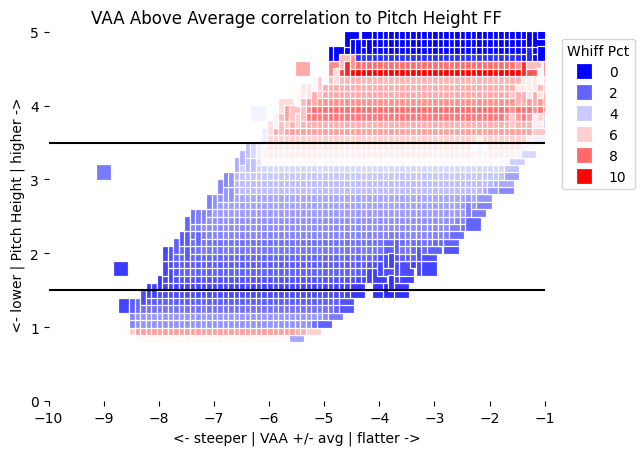

In [45]:
#plot the heatmap
sns.scatterplot(data=df_whiffs_ff.loc[df_whiffs_ff['plate_z'].between(.9,5)], x='vaa', y='plate_z',
                hue='whiff_pct', palette='bwr',
                marker='s', s=120)

plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Whiff Pct')
plt.axhline(1.5,c='k')
plt.axhline(3.5,c='k')
plt.xlim(-10,-1)
plt.ylim(0,5)
plt.title('VAA Above Average correlation to Pitch Height FF')
plt.xlabel('<- steeper | VAA +/- avg | flatter ->')
plt.ylabel(' <- lower | Pitch Height | higher ->')
sns.despine(left = True, bottom = True)
plt.show()

In [46]:
#get whiff rate by loc for normalized vaa
df_whiffs = df_vaaa.loc[:, ['game_year','pitcher','pitch_type','vaaa', 'plate_z','swing','whiff']].copy()

#round the data to nearest .1
df_whiffs['plate_z_bin'] = df_whiffs['plate_z'].round(1)

#average vaa for each pitch height
df_whiffs_summary = df_whiffs.loc[:,['pitch_type','plate_z_bin','swing','whiff']].groupby(['pitch_type','plate_z_bin'],as_index = False).sum().rename(columns = {'swing':'swing_tot','whiff':'whiff_tot'})
df_whiffs = pd.merge(df_whiffs, df_whiffs_summary, on = ['pitch_type','plate_z_bin'])

# take total whiffs and divide by total swings to get whiff rate
df_whiffs["whiff_pct"] = df_whiffs['whiff_tot'].div(df_whiffs["swing_tot"]) * 100

df_whiffs = df_whiffs.fillna(0)

In [47]:
#creating heatmap using scatterplot grouping by density of whiff pct
df_whiffs_ff = df_whiffs.loc[df_whiffs['pitch_type'] == 'FF', ['pitch_type','vaaa', 'plate_z','whiff_pct']].copy()

#round the data to nearest .1
for col in ['vaaa', 'plate_z']:
  df_whiffs_ff[col] = df_whiffs_ff[col].round(1)

#get an avg whiff rate for each interval of vaaa and plate_z
df_whiffs_ff = df_whiffs_ff.groupby(['pitch_type','vaaa', 'plate_z'], as_index=False).mean()

#pivot the heatmap by vaa to get a matrix representing the density for each point on the plot
heatmap_matrix_whiffs = pd.pivot_table(df_whiffs_ff, values='whiff_pct', index='plate_z', columns='vaaa')
#fill all empty cells with 0 as they will have 0 % whiff rate in plot
heatmap_matrix_whiffs = heatmap_matrix_whiffs.fillna(0)
#apply guassian filtering to smooth the matrix
heatmap_temp_whiffs = gaussian_filter(heatmap_matrix_whiffs, sigma=.75)
#transform the array back into df
heatmap_temp_whiffs = pd.DataFrame(heatmap_temp_whiffs, index=heatmap_matrix_whiffs.index, columns=heatmap_matrix_whiffs.columns)
heatmap_temp_whiffs = heatmap_temp_whiffs.reset_index()
#melt columns from wide to long
df_temp_whiffs = pd.melt(heatmap_temp_whiffs, id_vars='plate_z', value_name='whiff_pct')
#merge values back to original df
df_whiffs_ff = df_temp_whiffs.merge(df_whiffs_ff.loc[:, ['vaaa', 'plate_z']])

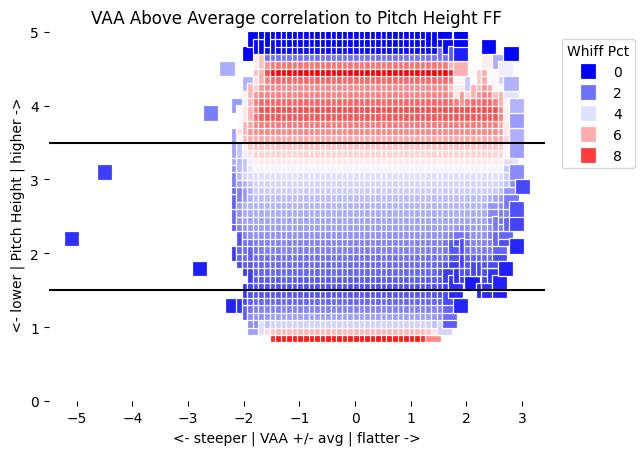

In [48]:
#plot the heatmap
sns.scatterplot(data=df_whiffs_ff.loc[df_whiffs_ff['plate_z'].between(.9,5)], x='vaaa', y='plate_z',
                hue='whiff_pct', palette='bwr',
                 marker='s', s=120)

plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Whiff Pct')
plt.axhline(1.5,c='k')
plt.axhline(3.5,c='k')
plt.ylim(0,5)
plt.title('VAA Above Average correlation to Pitch Height FF')
plt.xlabel('<- steeper | VAA +/- avg | flatter ->')
plt.ylabel(' <- lower | Pitch Height | higher ->')
sns.despine(left = True, bottom = True)
plt.show()

df['vaa'] = df_vaa['vaa']
df['vaaa'] = df_vaaa['vaaa']

In [49]:
#create horizontal approach angle feature HAA
df_haa = df.copy()
df_haa['vy_f'] = -np.sqrt(df_haa['vy0']**2 - 2 * df_haa['ay'] * (50 - 17/12))
df_haa['t'] = (df_haa['vy_f'] - df_haa['vy0']) / df_haa['ay']
df_haa['vx_f'] = df_haa['vx0'] + (df_haa['ax'] * df_haa['t'])
df_haa['haa'] = -np.arctan(df_haa['vx_f']/df_haa['vy_f']) * (180 / np.pi)

#take a look at a few pitcher's HAA for fastball in 2023 -  should be 1.3
print(df_haa['haa'].loc[(df_haa['pitcher'] == 450203) & (df_haa['pitch_type'] == 'FF') & (df_haa['game_year'] == 2023)].mean()) #charlie morton
print(round(df_haa['haa'].loc[(df_haa['pitcher'] == 592332) & (df_haa['pitch_type'] == 'FF') & (df_haa['game_year'] == 2023)].mean(),1)) #kevin gausman
print(round(df_haa['haa'].loc[(df_haa['pitcher'] == 543037) & (df_haa['pitch_type'] == 'FF') & (df_haa['game_year'] == 2023)].mean(),1)) #gerrit cole
print(df_haa['haa'].loc[(df_haa['pitcher'] == 664299) & (df_haa['pitch_type'] == 'FF') & (df_haa['game_year'] == 2023)].mean()) #christian javier
print(round(df_haa['haa'].loc[(df_haa['pitcher'] == 656302) & (df_haa['pitch_type'] == 'FF') & (df_haa['game_year'] == 2023)].mean(),1)) #dylan cease


#adjust horizontal movement for pitcher handedness (mirror across axis)
df_haa['haa_adj'] = df_haa['haa']
df_haa.loc[df_haa['p_throws'] == 'L','haa_adj'] = df_haa.loc[df_haa['p_throws'] == 'L', 'haa_adj'].mul(-1)

#adjust horizontal movement for release point centering the release point from either side of the mound
avg_rel_x = df_haa[['pitcher','pitch_type','release_pos_x_adj']].groupby(['pitcher','pitch_type']).mean().reset_index().rename(columns = {'release_pos_x_adj': 'release_pos_x_adj_avg'})
df_haa = df_haa.merge(avg_rel_x, on = ['pitcher','pitch_type'])
df_haa['release_pos_x_adj_diff'] = df_haa['release_pos_x_adj'].sub(df_haa['release_pos_x_adj_avg'])

#normalize HAA by subtracting the avg release point for each of their pitches
df_haa['haa_adj'] = df_haa['haa_adj'] - df_haa['release_pos_x_adj_diff']


1.231094315850731
1.3
1.3
1.2488877981274114
1.3


In [50]:
#normalize HAA by release position, location, and type of pitch
df_haaa = df_haa.loc[:, ['game_year','pitcher','pitch_type','haa_adj', 'plate_x', 'delta_run_exp', 'whiff', 'swing']].copy()

#round the data to nearest .1
for col in ['plate_x']:
  df_haaa['{}_bin'.format(col)] = df_haaa[col].round(1)

#average haa for each pitch location on x axis
df_haaa_summary = df_haaa.loc[:,['pitch_type','plate_x_bin','haa_adj']].groupby(['pitch_type','plate_x_bin'],as_index = False).mean().rename(columns = {'haa_adj':'haa_avg'})
df_haaa = pd.merge(df_haaa, df_haaa_summary, on = ['pitch_type','plate_x_bin'])

# take vaa and get the difference between the avg vaa and the vaa of each pitch
df_haaa['haaa'] = df_haaa['haa_adj'].sub(df_haaa['haa_avg'])


In [51]:
#viewing my horizontal approach angle above average as compared to the primers examples
print(df_haaa['haaa'].loc[(df_haaa['pitcher'] == 450203) & (df_haaa['pitch_type'] == 'FF') & (df_haaa['game_year'] == 2023)].mean()) #charlie morton
print(df_haaa['haaa'].loc[(df_haaa['pitcher'] == 592332) & (df_haaa['pitch_type'] == 'FF') & (df_haaa['game_year'] == 2023)].mean()) #kevin gausman
print(df_haaa['haaa'].loc[(df_haaa['pitcher'] == 543037) & (df_haaa['pitch_type'] == 'FF') & (df_haaa['game_year'] == 2023)].mean()) #gerrit cole
print(df_haaa['haaa'].loc[(df_haaa['pitcher'] == 664299) & (df_haaa['pitch_type'] == 'FF') & (df_haaa['game_year'] == 2023)].mean()) #christian javier
print(df_haaa['haaa'].loc[(df_haaa['pitcher'] == 656302) & (df_haaa['pitch_type'] == 'FF') & (df_haaa['game_year'] == 2023)].mean()) #dylan cease

0.12998976606956555
0.1325044041169646
0.0763954615396803
0.08012836857397206
-0.11227723073580967


In [52]:
#join my haa and haaa features back to my original dataset

#horizontal approach angle without any adjustments
df['haa'] = df_haa['haa']

#horizontal approach angle adjusted for pitcher handedness and release position
df['haa_adj'] = df_haa['haa_adj']

#horizontal approach angle adjusted for pitcher handedness and release position and pitch location
df['haaa'] = df_haaa['haaa']


In [53]:
#seam shifted wake features x and z dimensions

#define features used to estimate seam shifted wake and the target variables
feats = ['release_spin_rate','spin_axis']
targets = ['pfx_x_adj', 'pfx_z']

#folding the data allows for all data to be used within various models instead of splitting 80/20
folds = 3
kf = KFold(folds, shuffle=True) #shuffling ensures that the data is a random sample not impacted by index order

#create a place to store
ssw_output = {}
ssw_output['pfx_x_adj'] = pd.Series()
ssw_output['pfx_z'] = pd.Series()


#subset the data and drop missing values to model seam shifted wake
ssw_model_data = df.dropna(subset=feats+targets)

#loop through the data and create 3 different train test splits based on index
for train_idx, test_idx in kf.split(ssw_model_data):
  train = ssw_model_data.iloc[train_idx]
  test = ssw_model_data.iloc[test_idx]

  #loop through each train and test split and run xgb saving the output
  for target in targets:
    model = xgb.XGBRegressor(verbosity=1) #initialize model
    model.fit(train.loc[:, feats], train[target]) #fit training data
    preds = model.predict(test.loc[:, feats]) #predict on test data
    idx = test.index #save index of test data to return back to original df
    model_series = pd.Series(preds, index=idx) #store predictions and index
    ssw_output[target] = pd.concat([ssw_output[target], model_series]) #join predictions and index into series made out of loop to store all outputs

#create prediction columns with stored series
ssw_model_data['pfx_x_adj_pred'] = ssw_output['pfx_x_adj']
ssw_model_data['pfx_z_pred'] = ssw_output['pfx_z']

#take the difference between actual pitch movement and predicted movement to get the seam shifted wake
ssw_model_data['ssw_x'] = ssw_model_data['pfx_x_adj'].sub(ssw_model_data['pfx_x_adj_pred'])
ssw_model_data['ssw_z'] = ssw_model_data['pfx_z'].sub(ssw_model_data['pfx_z_pred'])

#return features to df that contains all features
df['ssw_x'] = ssw_model_data['ssw_x']
df['ssw_z'] = ssw_model_data['ssw_z']



<ipython-input-53-25f5248ff4fb>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssw_model_data['pfx_x_adj_pred'] = ssw_output['pfx_x_adj']
<ipython-input-53-25f5248ff4fb>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssw_model_data['pfx_z_pred'] = ssw_output['pfx_z']
<ipython-input-53-25f5248ff4fb>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

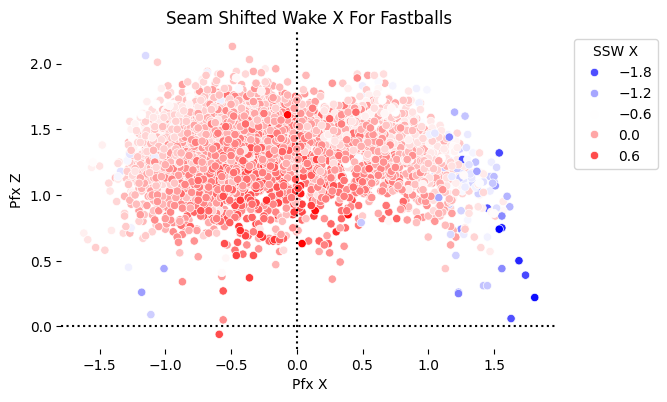

In [54]:
# # visual of seam shifted wake model x
sns.scatterplot(df.loc[df['pitch_type'] == 'FF'].sample(5000), x = 'pfx_x', y = 'pfx_z', hue = 'ssw_x',
                palette = 'bwr')

#set coordinates to be equal on x and y axes
plt.gca().set_aspect('equal')

#styling the viz
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='SSW X')
plt.title('Seam Shifted Wake X For Fastballs')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.xlabel('Pfx X')
plt.ylabel('Pfx Z')
sns.despine(left = True, bottom = True)
plt.show()

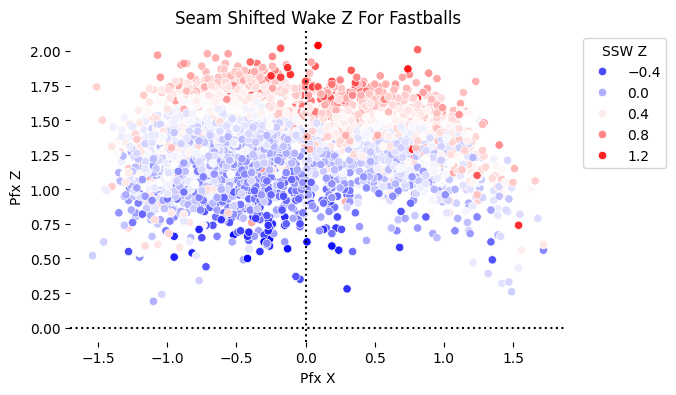

In [55]:
#visual of seam shifted wake model z
sns.scatterplot(df.loc[df['pitch_type'] == 'FF'].sample(5000), x = 'pfx_x', y = 'pfx_z', hue = 'ssw_z',
                palette = 'bwr')

#set coordinates to be equal on x and y axes
plt.gca().set_aspect('equal')

#styling the viz
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='SSW Z')
plt.title('Seam Shifted Wake Z For Fastballs')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.xlabel('Pfx X')
plt.ylabel('Pfx Z')
sns.despine(left = True, bottom = True)
plt.show()

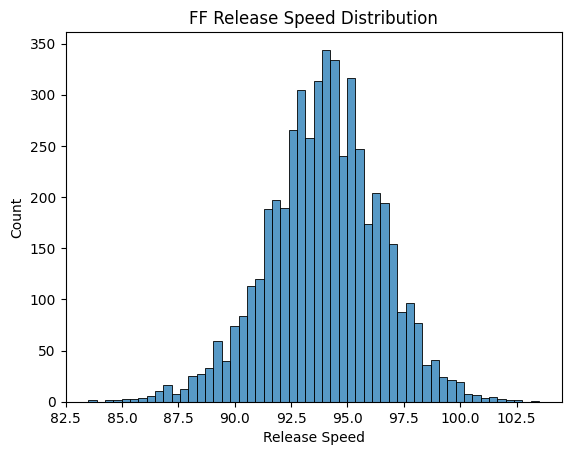

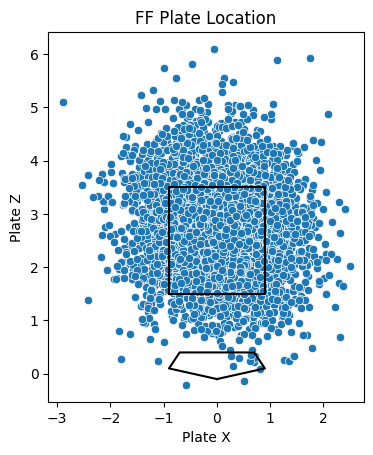

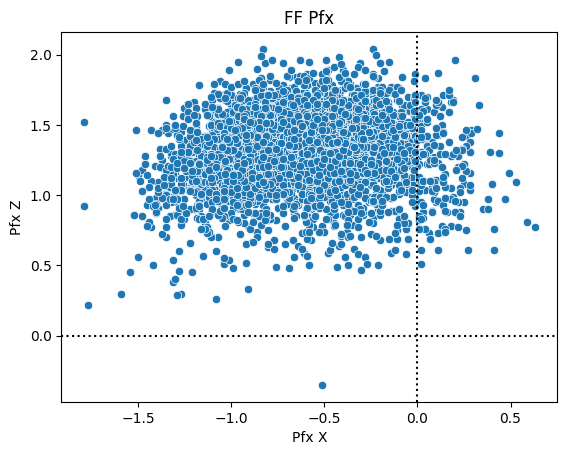

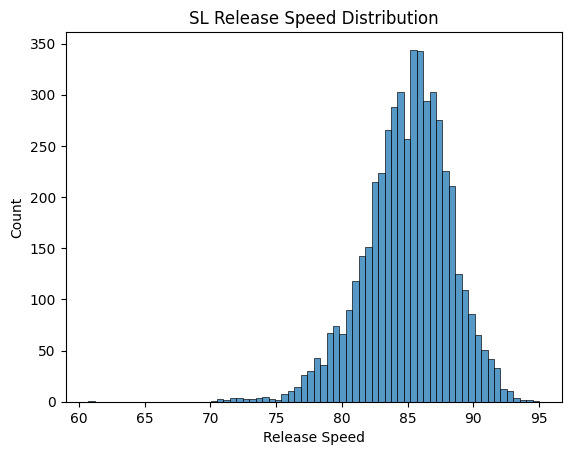

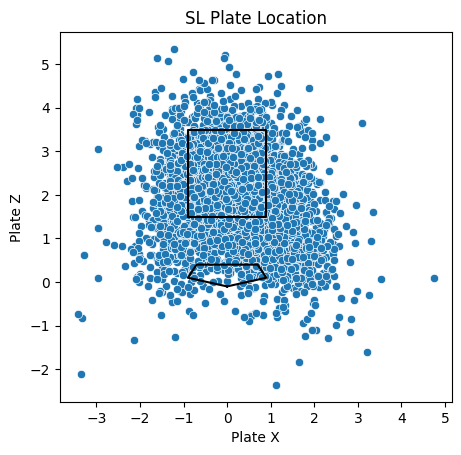

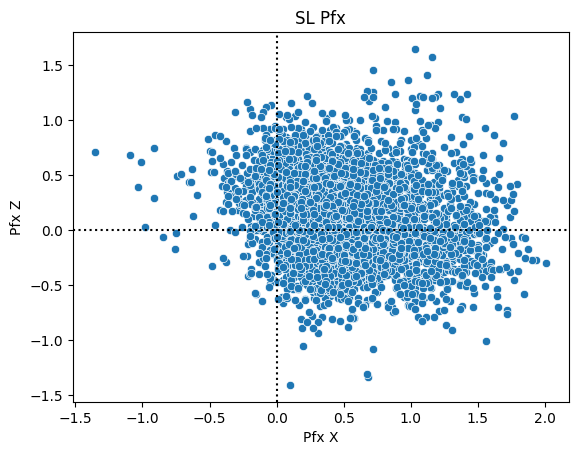

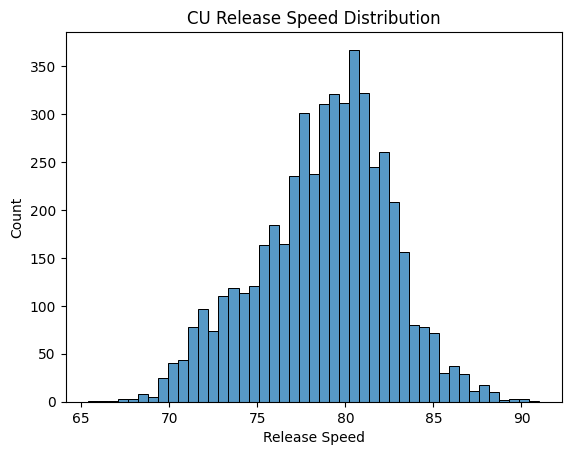

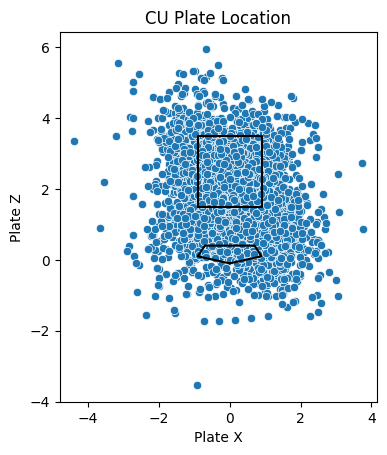

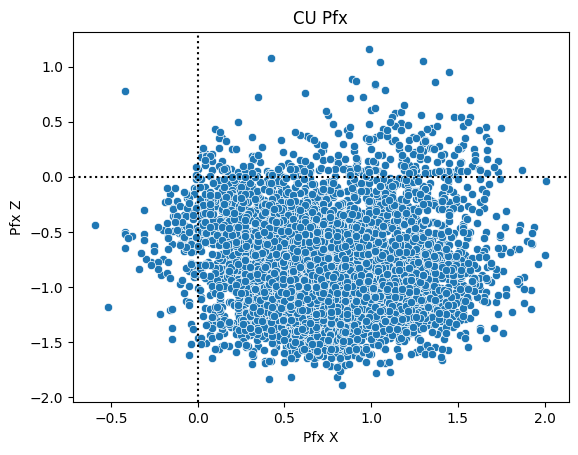

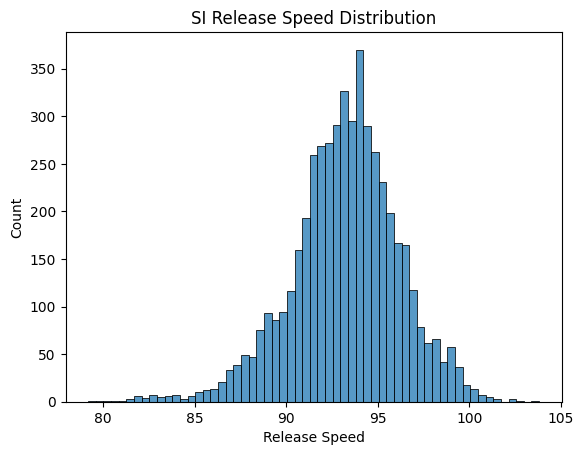

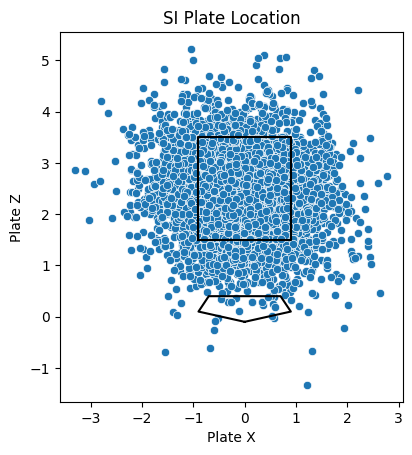

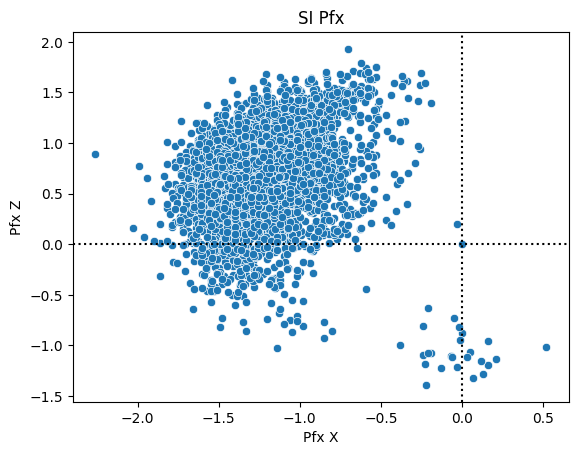

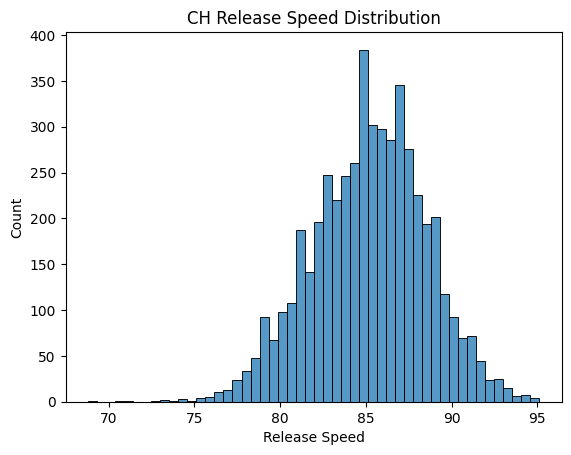

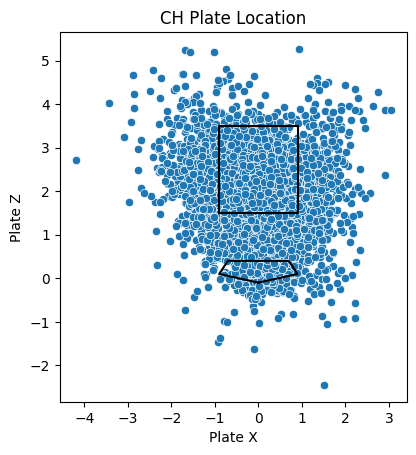

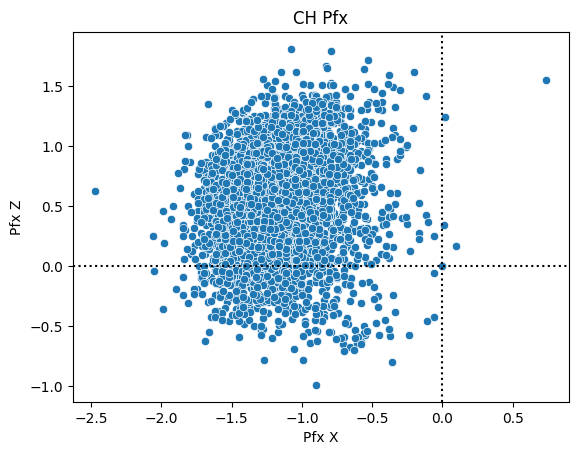

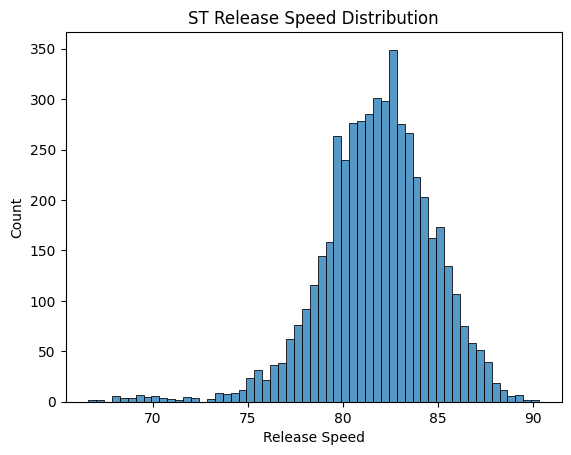

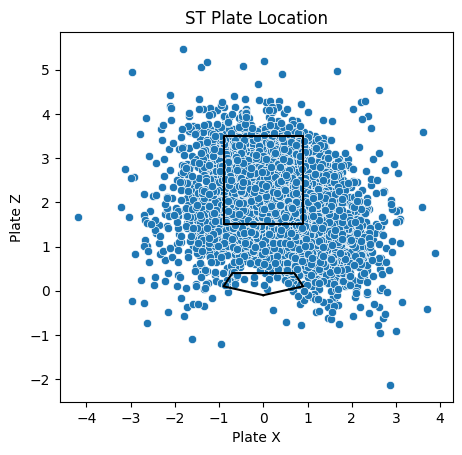

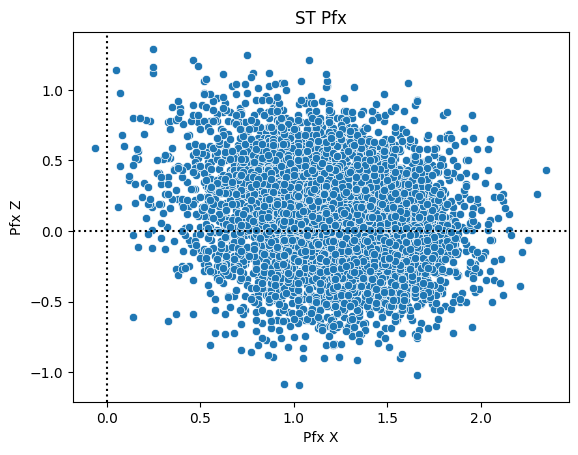

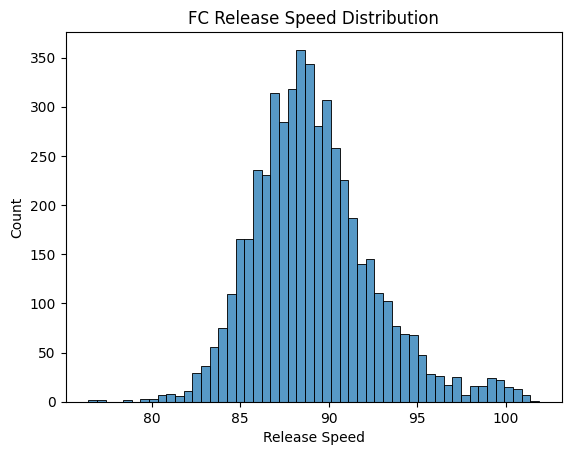

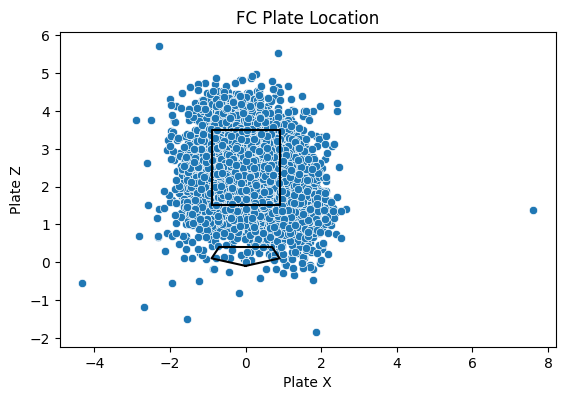

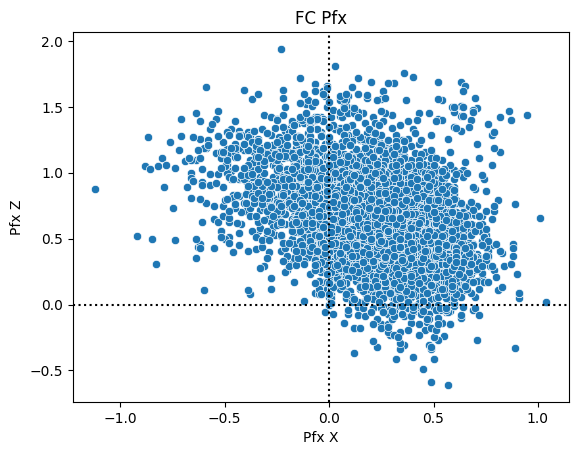

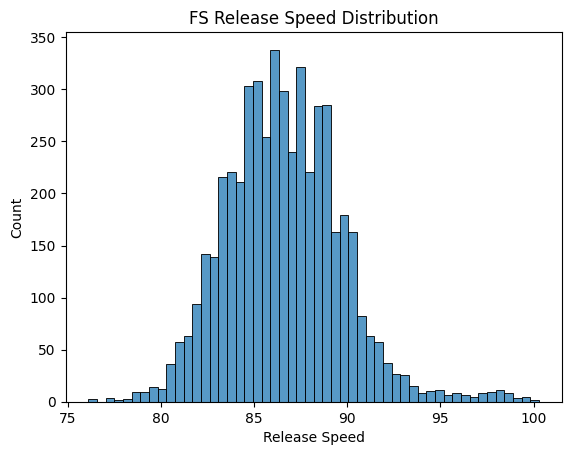

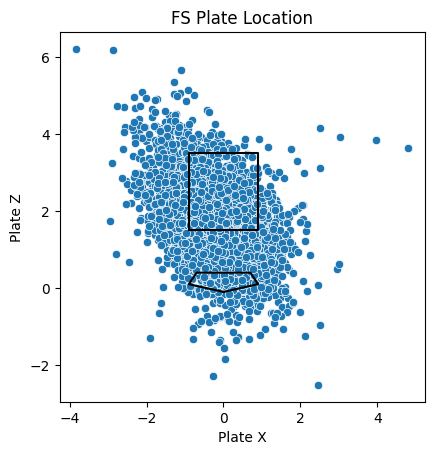

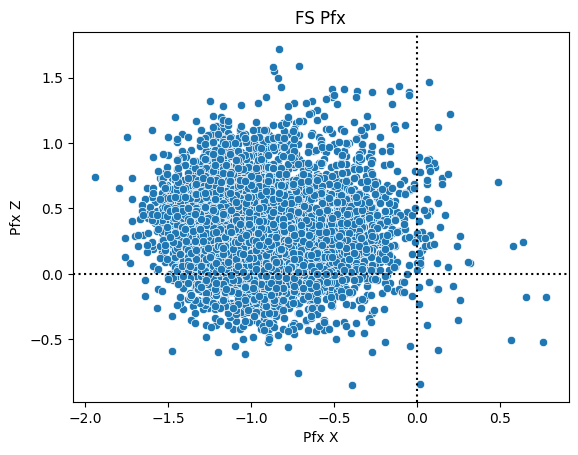

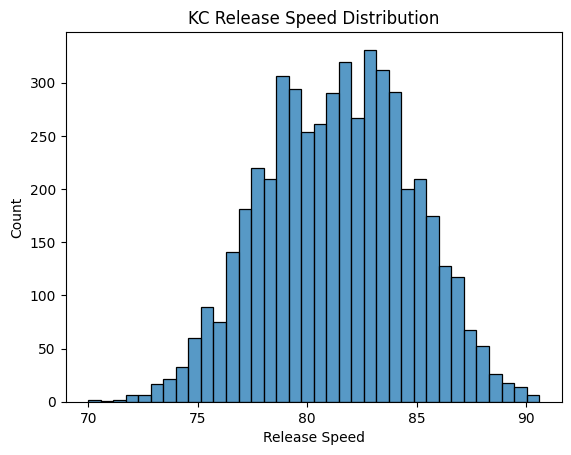

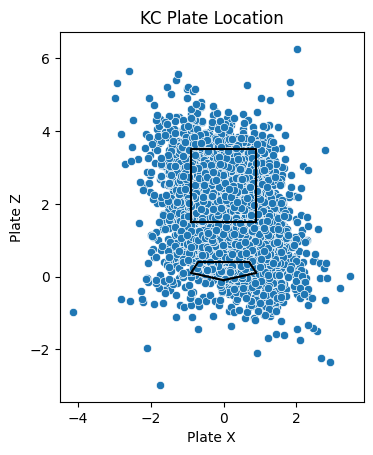

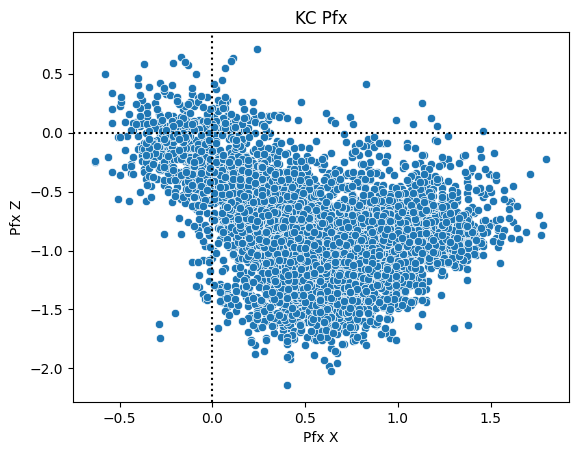

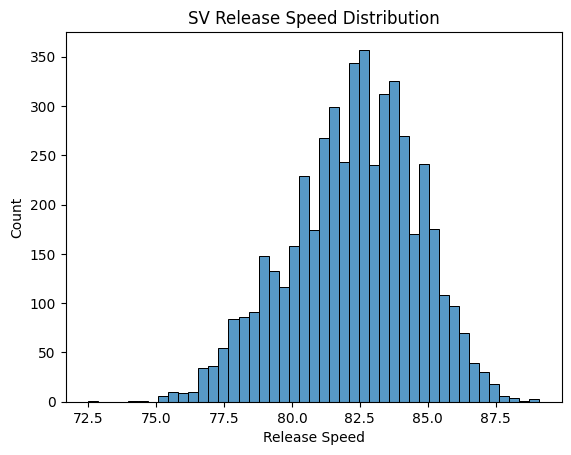

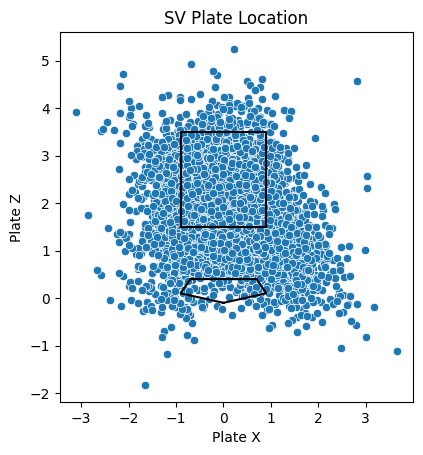

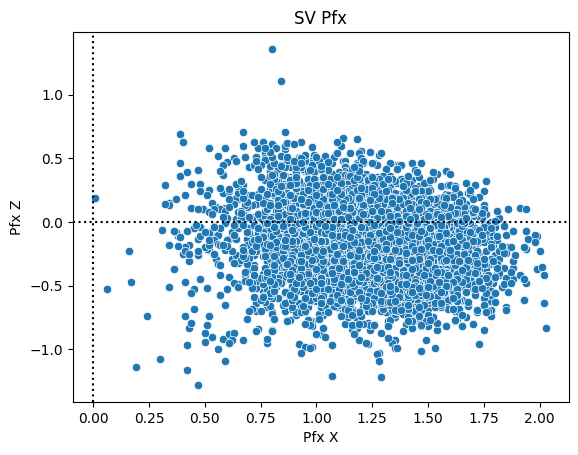

In [56]:
#filter for competitive pitches

#visualize the distributions for each pitch to help inform our decisions of competitive pitches in terms of speed
pitch_types = pitch_types = df.loc[df['pitch_family'] != 'Other']['pitch_type'].unique()

for p_type in pitch_types:
  #distribution plot
  sns.histplot(df['release_speed'].loc[df['pitch_type'] == p_type].sample(5000))
  plt.title(p_type + ' Release Speed Distribution')
  plt.xlabel('Release Speed')
  plt.ylabel('Count')
  plt.show()

  #vizualize pitch movement to make sure the pitch is moving is within reason
  sns.scatterplot(df.loc[df['pitch_type'] == p_type].sample(5000), x = 'plate_x', y = 'plate_z')
  plt.title(p_type + ' Plate Location')
  plt.xlabel('Plate X')
  plt.ylabel('Plate Z')


  #strike zone and home plate plotting
  hp_x = [0,-.9,-.7,.7,.9,0]
  hp_y = [-.1,.1,.4,.4,.1,-.1]
  plt.plot(hp_x,hp_y,'k-',zorder=1)

  sz_x = [-.9,-.9,.9,.9,-.9]
  sz_y = [1.5, 3.5, 3.5, 1.5, 1.5]
  plt.plot(sz_x,sz_y,'k-',zorder=1)

  #equal coordinates
  plt.gca().set_aspect('equal')
  plt.show()

  #pfx plot
  sns.scatterplot(df.loc[df['pitch_type'] == p_type].sample(5000), x = 'pfx_x_adj', y = 'pfx_z')
  plt.title(p_type + ' Pfx')
  plt.axhline(0,c='k', ls=':')
  plt.axvline(0,c='k', ls=':')
  plt.xlabel('Pfx X')
  plt.ylabel('Pfx Z')
  plt.show()


In [57]:
#best course of action for further outlier detection
#isolation forest to detect largest outliers in terms of plate location and pfx movement
#trim off the upper and lower bounds of the veloctity distribution

#isolation forest from sklearn

#initialize the features for the forest
descriptive_feats = ['pitch_type']
anomaly_feats = ['pfx_x_adj','pfx_z','plate_x','plate_z','release_speed']
iso_df = df[descriptive_feats + anomaly_feats].loc[df['pitch_type'].isin(pitch_types)].dropna()

#create a series to store the index and values of the output
iso_output = pd.Series()

#loop through pitch types and get the isolation scores
for p_type in pitch_types:
  iso_forest = IsolationForest(contamination=0.05)
  iso_forest.fit(iso_df[anomaly_feats].loc[iso_df['pitch_type'] == p_type])
  outlier_pitches = iso_forest.decision_function(iso_df[anomaly_feats].loc[iso_df['pitch_type'] == p_type])
  iso_out = pd.Series(outlier_pitches, index = iso_df.loc[iso_df['pitch_type'] == p_type].index)
  iso_output = pd.concat([iso_output, iso_out])

#merge outlier scores to the iso df
iso_df['outlier_score'] = iso_output


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

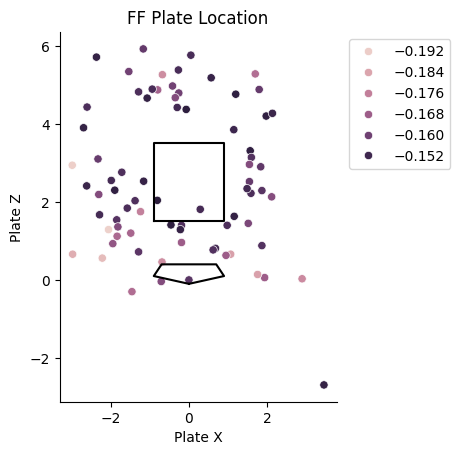

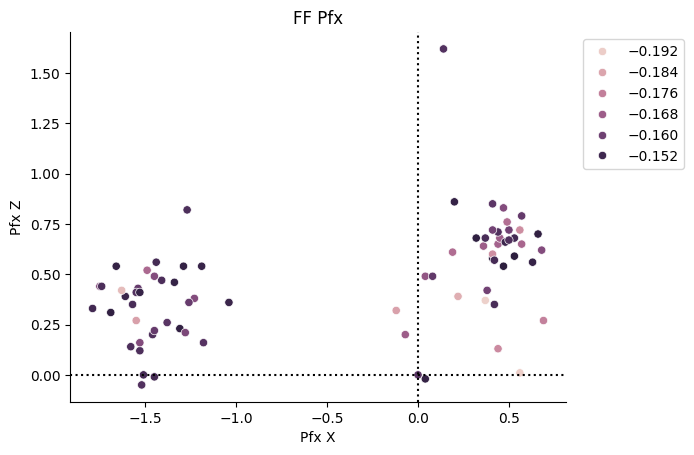

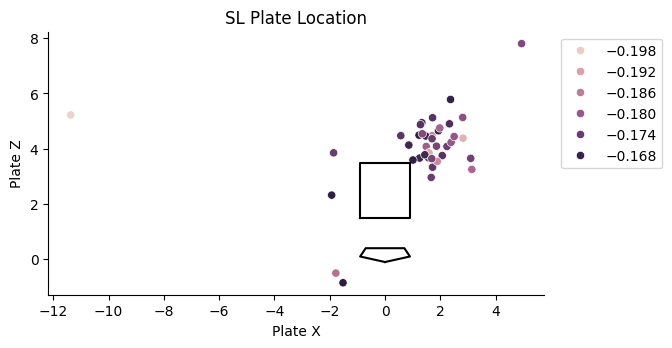

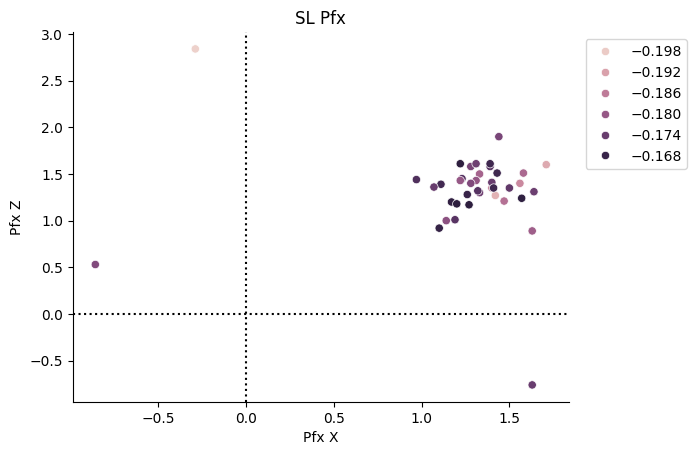

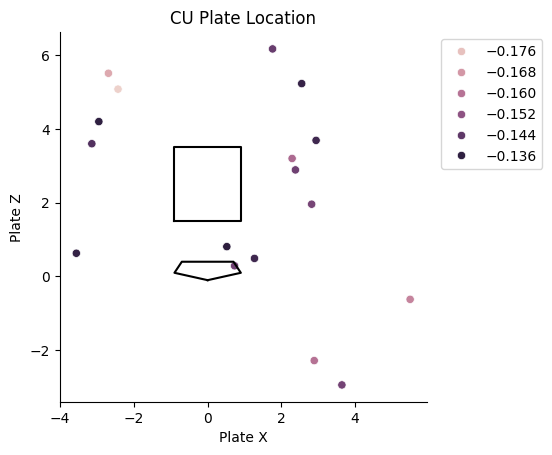

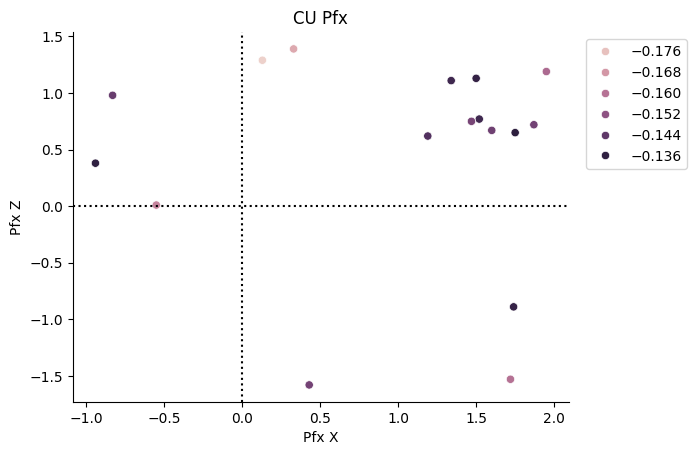

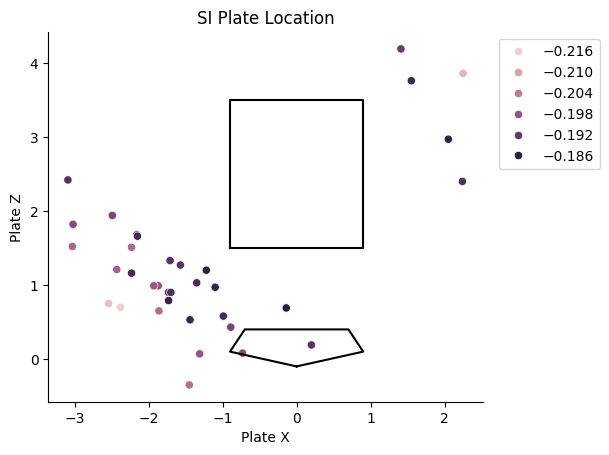

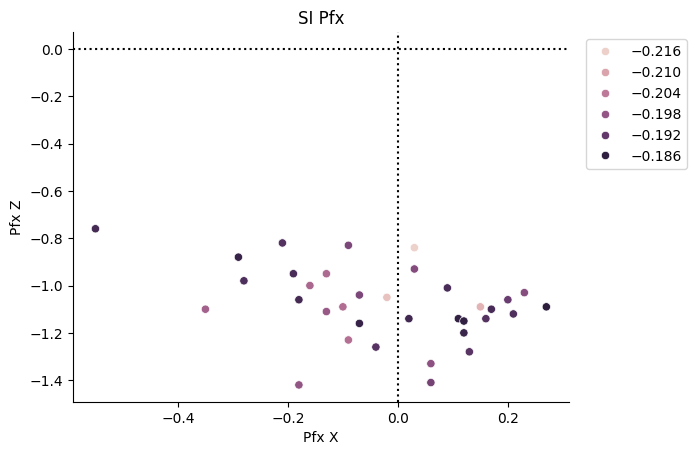

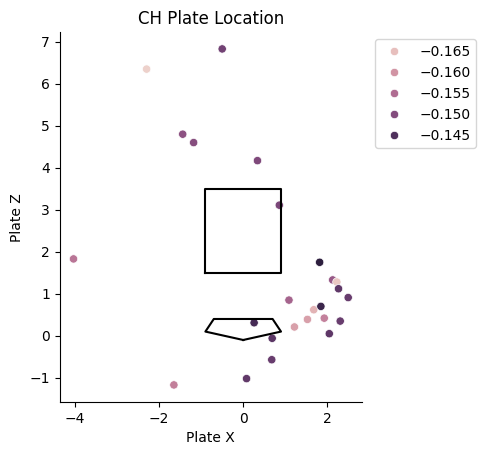

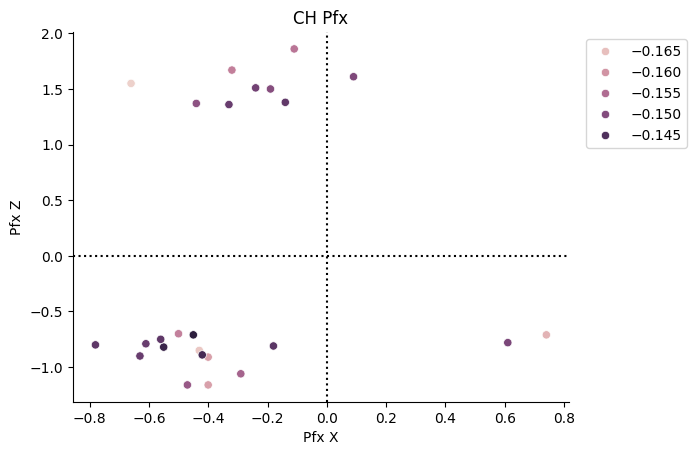

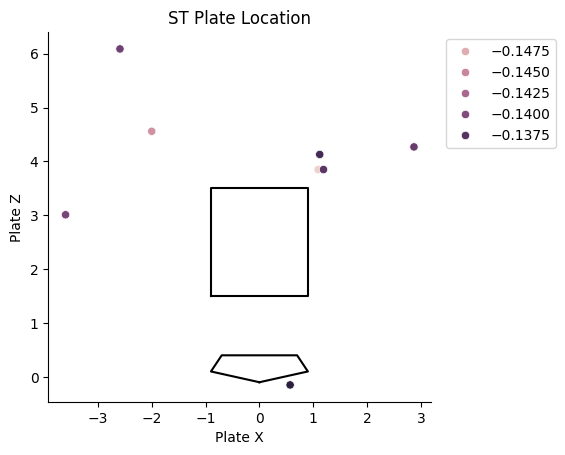

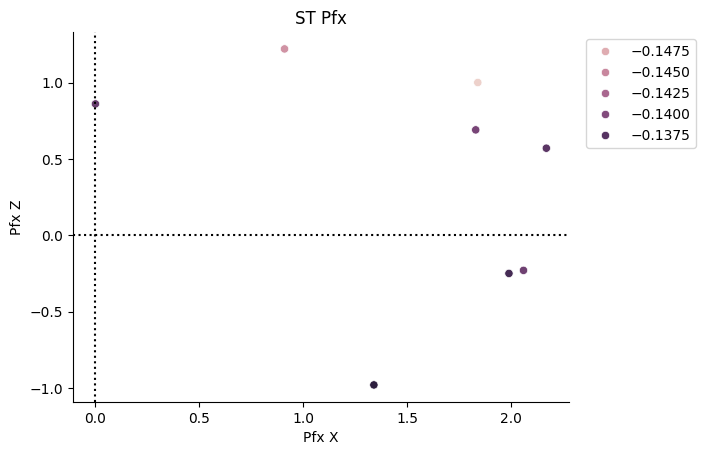

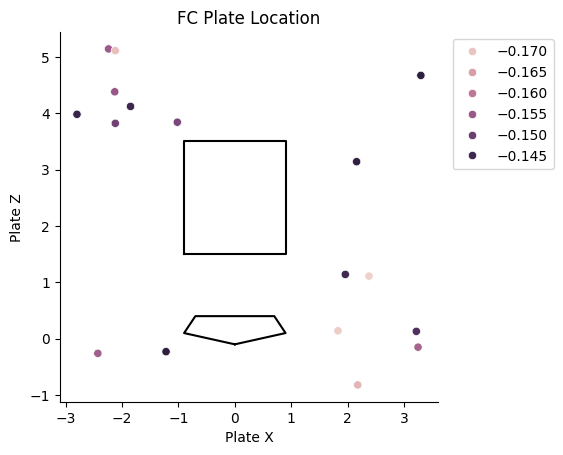

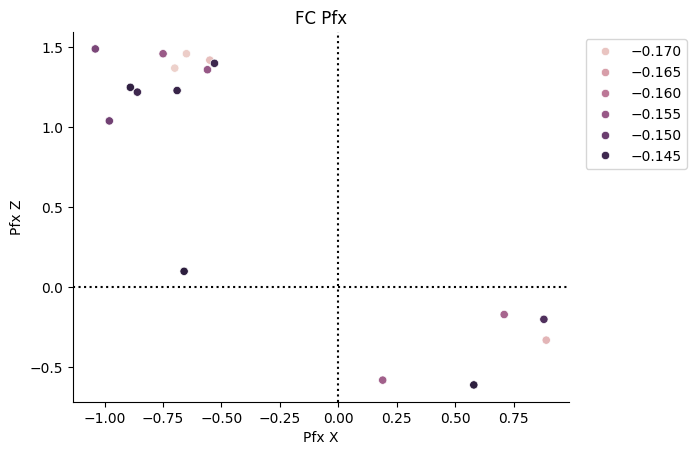

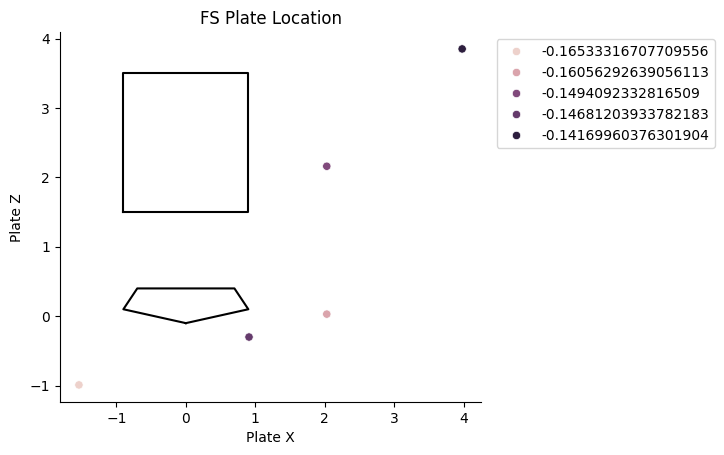

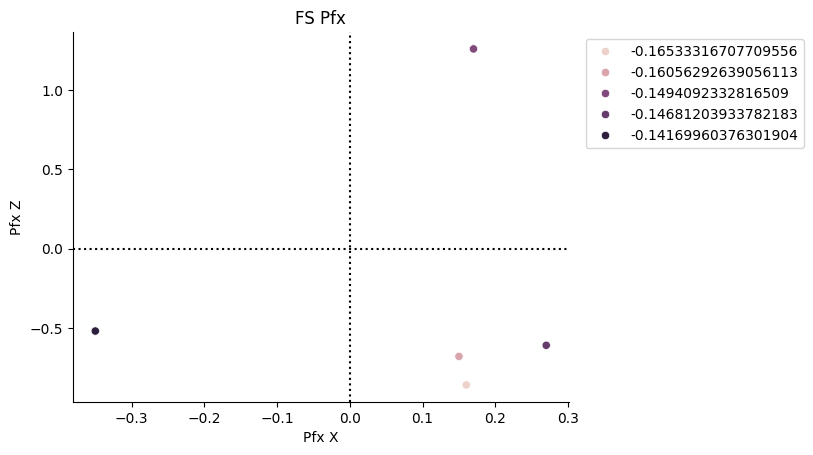

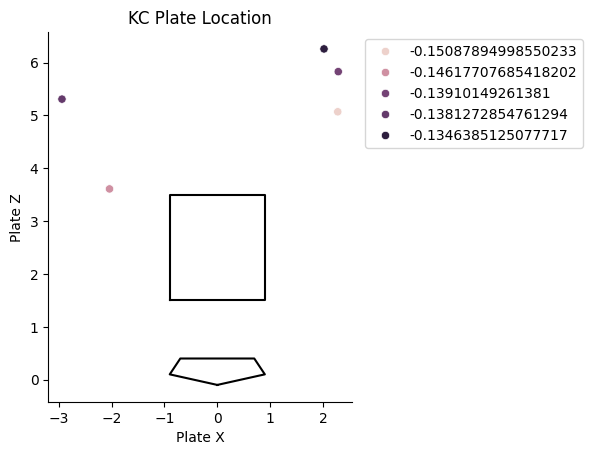

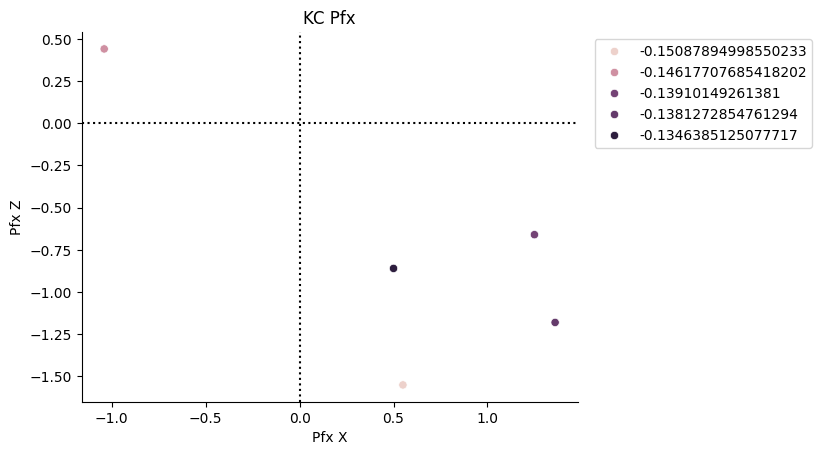

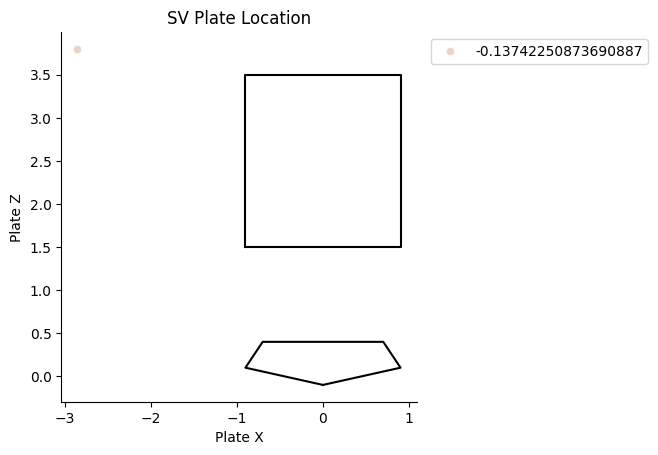

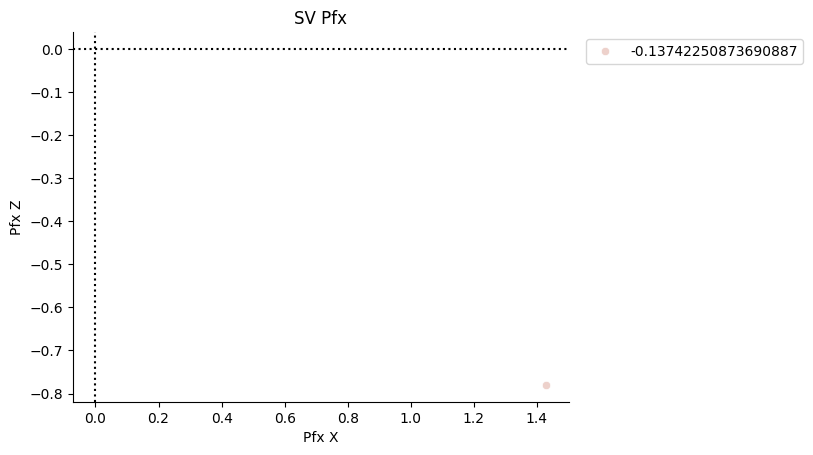

In [58]:
#vizualize pitch movement to make sure the pitch is moving is within reason
for p_type in pitch_types:
  #identify the subset of outliers using quantile
  bottom_outliers = iso_df['outlier_score'].loc[iso_df['pitch_type'] == p_type].quantile(0.0001)
  #filter the df for only the pitches marked as the most outstanding points
  p_outliers = iso_df.loc[(iso_df['outlier_score'] < bottom_outliers) & (iso_df['pitch_type'] == p_type)]
  #plot the outliers to visualize the points being removed
  sns.scatterplot(p_outliers, x = 'plate_x', y = 'plate_z', hue = 'outlier_score')
  plt.title(p_type + ' Plate Location')
  plt.xlabel('Plate X')
  plt.ylabel('Plate Z')
  plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
  sns.despine()

  #strike zone and home plate plotting
  hp_x = [0,-.9,-.7,.7,.9,0]
  hp_y = [-.1,.1,.4,.4,.1,-.1]
  plt.plot(hp_x,hp_y,'k-',zorder=1)

  sz_x = [-.9,-.9,.9,.9,-.9]
  sz_y = [1.5, 3.5, 3.5, 1.5, 1.5]
  plt.plot(sz_x,sz_y,'k-',zorder=1)

  #equal coordinates
  plt.gca().set_aspect('equal')
  plt.show()

  #pfx plot
  sns.scatterplot(p_outliers, x = 'pfx_x_adj', y = 'pfx_z', hue = 'outlier_score')
  plt.title(p_type + ' Pfx')
  plt.axhline(0,c='k', ls=':')
  plt.axvline(0,c='k', ls=':')
  plt.xlabel('Pfx X')
  plt.ylabel('Pfx Z')
  plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
  sns.despine()
  plt.show()


In [59]:
#identify the bottom outliers to remove from the df

#get the bottom scores by each pitch type
bottom_pct = iso_df[['pitch_type','outlier_score']].groupby('pitch_type').quantile(0.0001).reset_index().rename(columns = {'outlier_score' : 'bottom_pct'})
iso_df = iso_df.merge(bottom_pct, on = 'pitch_type')
#filter the df to view the amount of pitches being cut out by isolation forest - 228 pitches
outlier_isoforest = iso_df.loc[iso_df['outlier_score'] < iso_df['bottom_pct']]

#remove the 228 pitches
iso_df = iso_df.loc[iso_df['outlier_score'] >= iso_df['bottom_pct']]


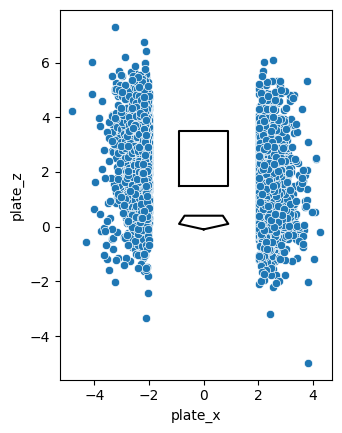

In [60]:
#last set of filtering for competitive pitches will be removing fastball pitches that move over 2ft in either direction as those are typically not competitve pitches or misreads

#829 pitches
iso_df.loc[~iso_df['pfx_x_adj'].between(-2,2) ]
#483 pitches
iso_df.loc[~iso_df['pfx_z'].between(-2,2)]

#filter for pitches way out off the plate - 40k pitches
iso_df.loc[~iso_df['plate_x'].between(-2,2)]

#remove expecptionally slow pitches - 32 pitches
iso_df.loc[iso_df['release_speed'] < 60]

#visual of pitches outside the zone
sns.scatterplot(iso_df.loc[~iso_df['plate_x'].between(-2,2)].sample(5000), x = 'plate_x', y = 'plate_z')
#strike zone and home plate plotting
hp_x = [0,-.9,-.7,.7,.9,0]
hp_y = [-.1,.1,.4,.4,.1,-.1]
plt.plot(hp_x,hp_y,'k-',zorder=1)

sz_x = [-.9,-.9,.9,.9,-.9]
sz_y = [1.5, 3.5, 3.5, 1.5, 1.5]
plt.plot(sz_x,sz_y,'k-',zorder=1)

#equal coordinates
plt.gca().set_aspect('equal')
plt.show()
plt.show()

#remove all non competitive pitches - about 41k
iso_df = iso_df.loc[(iso_df['pfx_x_adj'].between(-2,2)) & (iso_df['pfx_z'].between(-2,2)) & (iso_df['plate_x'].between(-2,2)) & iso_df['release_speed'] < 60]

#remove non competitve pitches from main df using indexing of the isolation df
iso_df_idx = iso_df.index
df = df.iloc[iso_df_idx]

#reset index after filtering
df = df.reset_index()


In [70]:
#build optimization function defining the objective

#define features and target
descriptive_feats = ['game_year','pitcher','pitch_name','pitch_type', 'pitch_family_code', 'pitch_family']
model_feats = ['release_pos_x_adj','release_pos_z','release_speed','release_spin_rate','spin_axis',
               'release_extension','pfx_x_adj','pfx_z','release_speed_diff',
               'vaaa','haaa','ssw_x','ssw_z']
target = ['delta_run_exp']

pitch_family_types = df['pitch_family'].unique()

#create model dataframe
model_df = df[descriptive_feats + model_feats + target].dropna().reset_index()

X = model_df[model_feats]
y = model_df[target]


#define objective function
def objective(trial, X = X, y = y):

    #split data using train and test split from sklearn 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

    #define parameters to test
    param = {
        # 'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        # 'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.03,0.1,0.15,0.2, 0.3]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds' : 100
    }

    #set model with parameter search space
    model = xgb.XGBRegressor(**param)

    #fit the model
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=False)

    #make predictions
    preds = model.predict(X_test)

    #evalutate the model based on mean squared error
    mse = mean_squared_error(y_test, preds, squared=False)

    return mse

In [71]:
#build out the optuna parameter search study
study = optuna.create_study(direction='minimize') #objective is to minimize the mean squared error
study.optimize(objective, n_trials = 30) #30 trails to be completed
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-06-25 19:18:20,384] A new study created in memory with name: no-name-b03c1cd5-a4e3-4277-8080-d254ebbd55f3
[I 2024-06-25 19:19:32,653] Trial 0 finished with value: 0.24300829229536777 and parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 122}. Best is trial 0 with value: 0.24300829229536777.
[I 2024-06-25 19:20:14,107] Trial 1 finished with value: 0.2429662937287178 and parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 133}. Best is trial 1 with value: 0.2429662937287178.
[I 2024-06-25 19:20:25,968] Trial 2 finished with value: 0.2429795063300569 and parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 202}. Best is trial 1 with value: 0.2429662937287178.
[I 2024-06-25 19:20:51,850] Trial 3 finished with value: 0.24299572961644114 and parameters: {'colsample_bytree': 0.5, 'learni

Number of finished trials: 30
Best trial: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 80}


In [72]:
#visualize how the study went
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.243008 2024-06-25 19:18:20.386623 2024-06-25 19:19:32.653413   
1        1  0.242966 2024-06-25 19:19:32.655100 2024-06-25 19:20:14.106875   
2        2  0.242980 2024-06-25 19:20:14.109960 2024-06-25 19:20:25.968294   
3        3  0.242996 2024-06-25 19:20:25.970124 2024-06-25 19:20:51.850268   
4        4  0.243062 2024-06-25 19:20:51.852009 2024-06-25 19:21:07.142122   
5        5  0.242983 2024-06-25 19:21:07.144502 2024-06-25 19:21:19.743137   
6        6  0.242966 2024-06-25 19:21:19.744974 2024-06-25 19:21:35.236961   
7        7  0.243079 2024-06-25 19:21:35.239065 2024-06-25 19:21:50.435954   
8        8  0.243004 2024-06-25 19:21:50.439541 2024-06-25 19:22:03.369645   
9        9  0.242981 2024-06-25 19:22:03.371964 2024-06-25 19:22:17.895379   
10      10  0.242960 2024-06-25 19:22:17.897473 2024-06-25 19:24:00.122899   
11      11  0.242960 2024-06-25 19:24:00.124768 2024-06-25 19:25:23.524535   
12      12  0.242975 2024-06-25 19:25:23.526762 2024-06-25 19:25:45.612903   
13      13  0.242976 2024-06-25 19:25:45.616362 2024-06-25 19:26:08.552240   
14      14  0.242959 2024-06-25 19:26:08.554566 2024-06-25 19:27:29.188929   
15      15  0.242959 2024-06-25 19:27:29.191722 2024-06-25 19:28:48.530857   
16      16  0.242961 2024-06-25 19:28:48.532958 2024-06-25 19:29:08.243439   
17      17  0.243025 2024-06-25 19:29:08.245308 2024-06-25 19:29:22.314721   
18      18  0.242966 2024-06-25 19:29:22.316578 2024-06-25 19:30:17.064328   
19      19  0.242960 2024-06-25 19:30:17.066160 2024-06-25 19:31:03.926815   
20      20  0.242962 2024-06-25 19:31:03.930294 2024-06-25 19:32:13.778718   
21      21  0.242959 2024-06-25 19:32:13.780572 2024-06-25 19:33:30.073321   
22      22  0.242960 2024-06-25 19:33:30.075728 2024-06-25 19:34:36.213449   
23      23  0.242959 2024-06-25 19:34:36.215705 2024-06-25 19:36:13.910504   
24      24  0.242959 2024-06-25 19:36:13.912961 2024-06-25 19:37:37.867180   
25      25  0.242961 2024-06-25 19:37:37.869479 2024-06-25 19:38:56.392468   
26      26  0.242960 2024-06-25 19:38:56.394846 2024-06-25 19:39:14.593801   
27      27  0.243065 2024-06-25 19:39:14.596120 2024-06-25 19:39:29.871751   
28      28  0.242970 2024-06-25 19:39:29.874631 2024-06-25 19:40:24.971975   
29      29  0.242968 2024-06-25 19:40:24.974325 2024-06-25 19:40:43.119642   

                 duration  params_colsample_bytree  params_learning_rate  \
0  0 days 00:01:12.266790                      0.3                  0.01   
1  0 days 00:00:41.451775                      0.3                  0.10   
2  0 days 00:00:11.858334                      0.6                  0.30   
3  0 days 00:00:25.880144                      0.5                  0.03   
4  0 days 00:00:15.290113                      1.0                  0.30   
5  0 days 00:00:12.598635                      0.7                  0.15   
6  0 days 00:00:15.491987                      0.5                  0.30   
7  0 days 00:00:15.196889                      0.5                  0.20   
8  0 days 00:00:12.930104                      0.3                  0.30   
9  0 days 00:00:14.523415                      0.7                  0.10   
10 0 days 00:01:42.225426                      0.9                  0.03   
11 0 days 00:01:23.399767                      0.9                  0.03   
12 0 days 00:00:22.086141                      0.9                  0.03   
13 0 days 00:00:22.935878                      0.9                  0.03   
14 0 days 00:01:20.634363                      0.9                  0.03   
15 0 days 00:01:19.339135                      0.8                  0.03   
16 0 days 00:00:19.710481                      0.8                  0.20   
17 0 days 00:00:14.069413                      0.4                  0.15   
18 0 days 00:00:54.747750                      0.8                  0.01   
19 0 days 00:00:46.860655                      0.8               

In [73]:
#visualize the progression of the study
optuna.visualization.plot_optimization_history(study)

In [74]:
#view how each feature was progressing
optuna.visualization.plot_slice(study)

In [75]:
#visualize parameter importance plot
optuna.visualization.plot_param_importances(study)

In [76]:
#define the best trail to use for the model building phase
best_trial = study.best_trial.params
best_trial

{'colsample_bytree': 0.6,
 'learning_rate': 0.03,
 'max_depth': 3,
 'random_state': 2020,
 'min_child_weight': 80}

In [95]:
#create stuff model using features created above

#define features and target
descriptive_feats = ['game_year','pitcher','pitcher_name','pitch_name','pitch_type', 'pitch_family_code', 'pitch_family']
model_feats = ['release_pos_x_adj','release_pos_z','release_speed','release_spin_rate','spin_axis',
               'release_extension','pfx_x_adj','pfx_z','release_speed_diff',
               'vaaa','haaa','ssw_x','ssw_z']
target = ['delta_run_exp']

pitch_family_types = df['pitch_family'].unique()

#create model dataframe
model_df = df[descriptive_feats + model_feats + target].dropna().reset_index()

#use kfold just like with ssw to utilize all data in train and test sets
folds = 3
kf = KFold(folds, shuffle=True)

#create a series to store index and model predictions
xrv_output = pd.Series()

#create a dataframe to store feature importance of each model
var_imp_df = pd.DataFrame()

#loop through each pitch family
for p_type in pitch_family_types:
  _model_data = model_df.loc[model_df['pitch_family']== p_type].copy()
  #within each family split and run xgboost across all 3 folds
  for train_idx, test_idx in kf.split(_model_data):
    train = _model_data.iloc[train_idx] #split by train index
    test = _model_data.iloc[test_idx] #split by test index

    #run xgb model
    model = xgb.XGBRegressor(**best_trial) #initialize model with the best fit hyperparameters
    model.fit(train.loc[:, model_feats], train[target]) #fit training data

    #get var importance shap plot - takes too long need faster method
    # explainer = shap.Explainer(model) #run shap to get feature importance data about the model
    # shap_values = explainer(train.loc[:, model_feats])
    # shap.plots.beeswarm(shap_values)

    #get base xgb feature importance from model
    feature_important = model.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    _var_imp_df = pd.DataFrame(data=values, columns=['score'])
    _var_imp_df['feature'] = keys
    _var_imp_df['pitch_family'] = p_type
    var_imp_df = pd.concat([var_imp_df, _var_imp_df])

    preds = model.predict(test.loc[:, model_feats]) #predict on test data
    idx = test.index #save index of test data to return back to original df
    model_series = pd.Series(preds, index=idx) #store predictions and index
    xrv_output = pd.concat([xrv_output, model_series]) #join predictions and index into series made out of loop to store all outputs


model_df['xrv'] = xrv_output

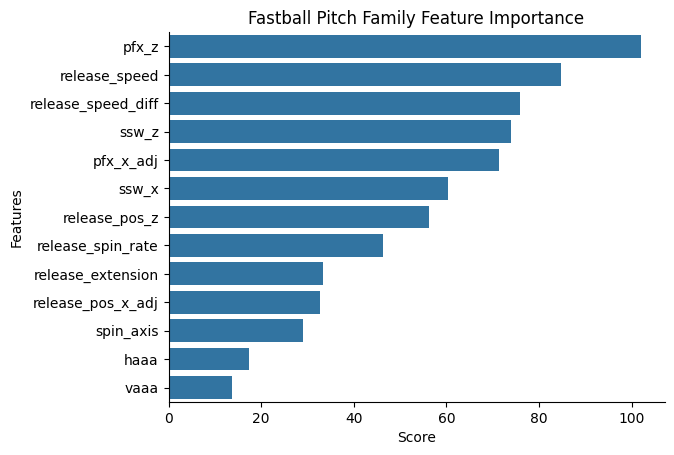

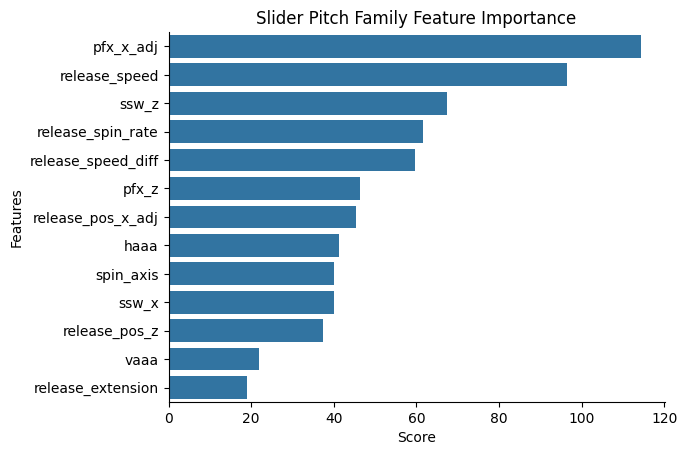

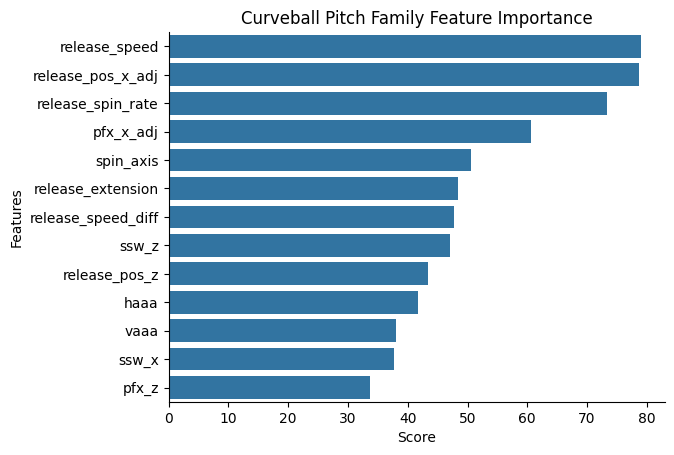

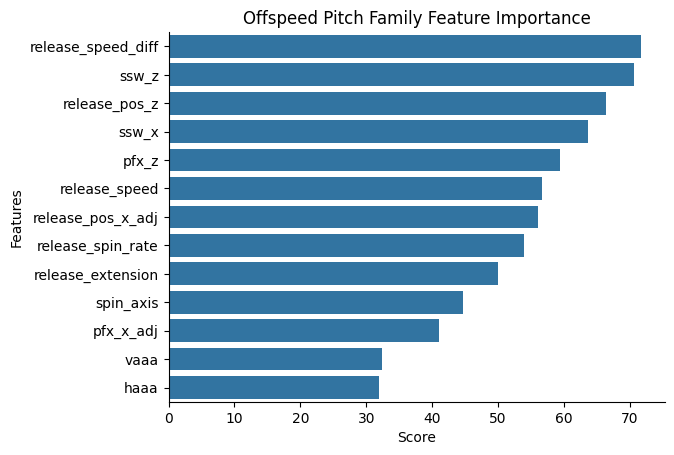

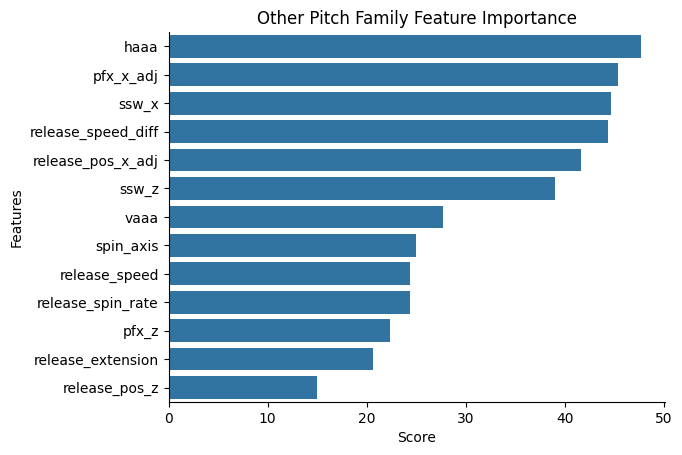

In [96]:
#plot avg importance for each pitch family
var_imp_summary_df = var_imp_df.groupby(['pitch_family','feature']).mean().reset_index()

for p_type in pitch_family_types:
  p_type_vap_imp_plot = var_imp_summary_df.loc[var_imp_summary_df['pitch_family'] == p_type].sort_values(by = 'score', ascending = False)
  sns.barplot(data = p_type_vap_imp_plot, x = 'score', y = 'feature')
  sns.despine()
  plt.title(p_type + ' Pitch Family Feature Importance')
  plt.xlabel('Score')
  plt.ylabel('Features')
  plt.show()

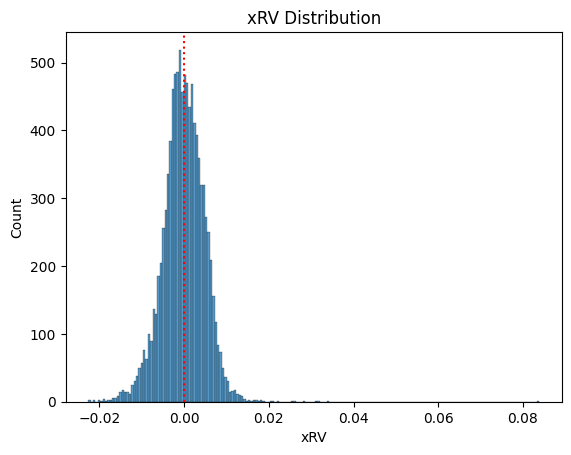

              xrv
count  2151942.00
mean        -0.00
std          0.00
min         -0.07
25%         -0.00
50%         -0.00
75%          0.00
max          0.12


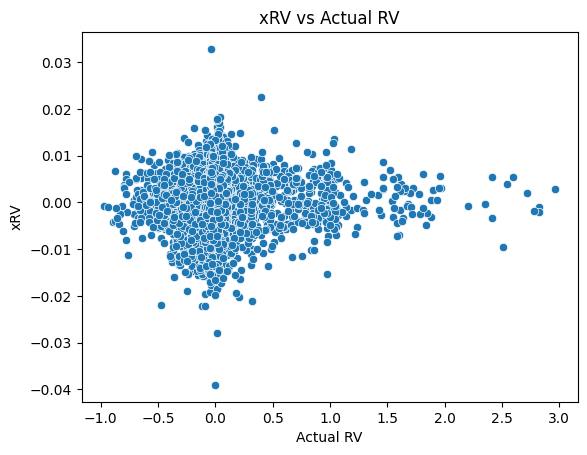

In [97]:
#distribution of xrv
sns.histplot(model_df['xrv'].sample(10000))
plt.title('xRV Distribution')
plt.xlabel('xRV')
plt.ylabel('Count')
plt.axvline(model_df['xrv'].mean(),  c='r', ls = ':')
plt.show()

#info about xrv column
print(model_df[['xrv']].describe().applymap(lambda x: f"{x:0.2f}"))

#actual vs expected run value plot
sns.scatterplot(model_df.sample(10000), x = 'delta_run_exp', y = 'xrv')
plt.title('xRV vs Actual RV')
plt.xlabel('Actual RV')
plt.ylabel('xRV')
plt.show()

In [98]:
stuff_output = pd.Series()

#converting xrv to stuff values by shifting the data points by the max xrv before creating plus metric
for p_type in pitch_family_types:
  #locate max for each pitch type
  max_xrv = round(abs(model_df['xrv'].loc[model_df['pitch_family'] == p_type].max()),3)+0.001
  #shift the data and flip to create positive values
  xrv_shifted = model_df['xrv'].loc[model_df['pitch_family'] == p_type].sub(max_xrv).mul(-1)
  #create plus metric
  stuff = round((xrv_shifted/xrv_shifted.mean()) *100)
  model_df['stuff+ {}'.format(p_type)] = stuff
  stuff_output = pd.concat([stuff_output, stuff])

model_df['stuff+'] = stuff_output

#change any stuff values that are exactly the mean to 100 as they would be converted to 0
model_df['stuff+'] = model_df['stuff+'].replace(0,100)

print(model_df['stuff+'].describe().round(3))

count    2151942.000
mean         100.000
std           22.018
min            1.000
25%           89.000
50%           99.000
75%          108.000
max          268.000
Name: stuff+, dtype: float64


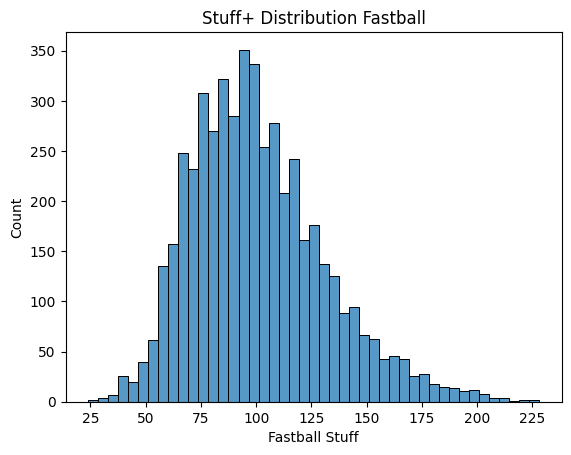

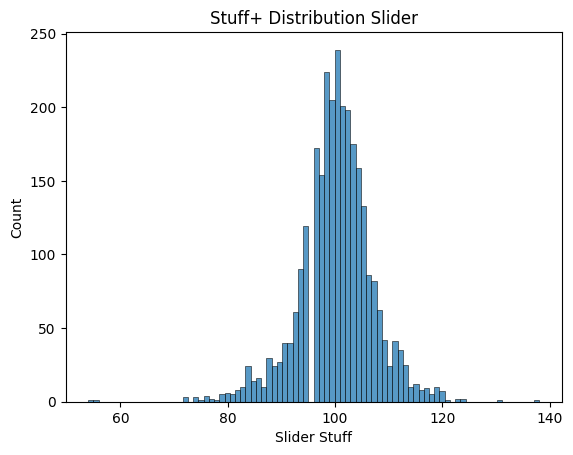

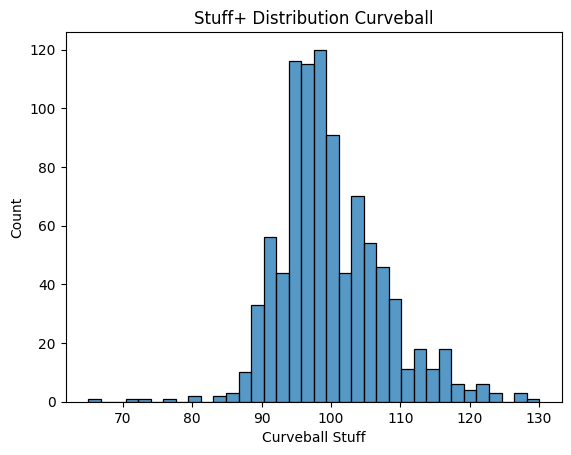

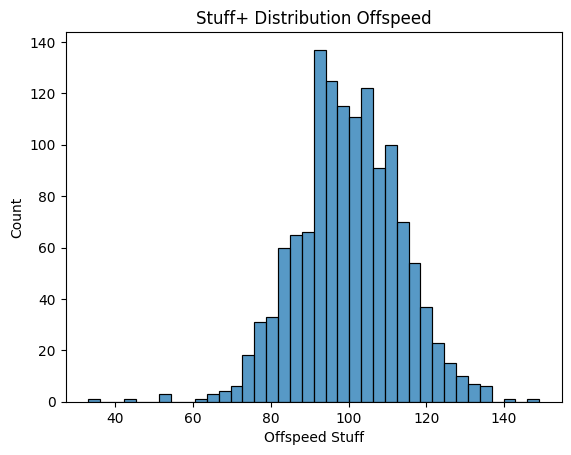

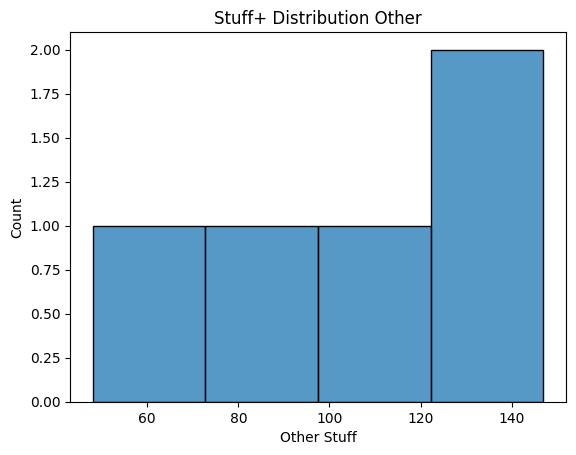

In [99]:
#distribution of xrv
for p_type in pitch_family_types:
  sns.histplot(model_df['stuff+ {}'.format(p_type)].sample(10000))
  plt.title('Stuff+ Distribution {}'.format(p_type))
  plt.xlabel('{} Stuff'.format(p_type))
  plt.ylabel('Count')
  plt.show()

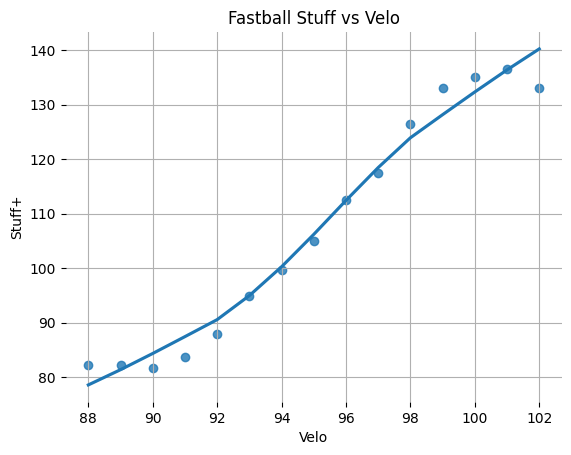

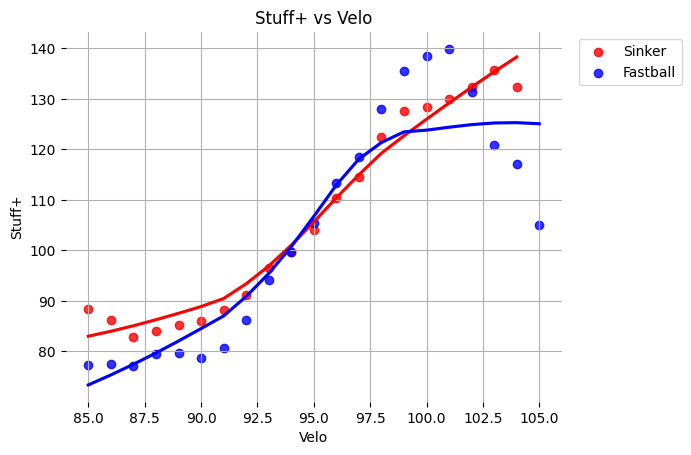

In [100]:
#fastball stuff vs velocity plot
fb_stuff_summary = model_df[['stuff+ Fastball','release_speed']].loc[(model_df['pitch_family']=='Fastball') & model_df['release_speed'].between(88,102)]
fb_stuff_summary['release_speed'] = round(fb_stuff_summary['release_speed'])
fb_stuff_summary = fb_stuff_summary.groupby('release_speed').mean().reset_index()

sns.regplot(fb_stuff_summary, x = 'release_speed', y = 'stuff+ Fastball', lowess=True)
sns.despine(left = True, bottom = True)
plt.title('Fastball Stuff vs Velo')
plt.xlabel('Velo')
plt.ylabel('Stuff+')
plt.grid()
plt.show()

#sinker vs fastball stuff plot
fb_si_stuff_summary = model_df[['stuff+ Fastball','release_speed','pitch_type']].loc[(model_df['pitch_family']=='Fastball') & model_df['release_speed'].between(85,105)]
fb_si_stuff_summary['release_speed'] = round(fb_si_stuff_summary['release_speed'])
fb_si_stuff_summary = fb_si_stuff_summary.groupby(['release_speed','pitch_type']).mean().reset_index()

sns.regplot(fb_si_stuff_summary.loc[fb_si_stuff_summary['pitch_type'] == 'SI'], x = 'release_speed', y = 'stuff+ Fastball', lowess=True, color = 'r', label = 'Sinker')
sns.regplot(fb_si_stuff_summary.loc[fb_si_stuff_summary['pitch_type'] == 'FF'], x = 'release_speed', y = 'stuff+ Fastball', lowess=True, color = 'b', label = 'Fastball')
sns.despine(left = True, bottom = True)
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.title('Stuff+ vs Velo')
plt.xlabel('Velo')
plt.ylabel('Stuff+')
plt.grid()
plt.show()




In [101]:
#stuff density plot over pitch movement (stuff by shape)

#std velocity 5.960 and avg 89.900
# round(model_df['release_speed'].describe(),3)

#filter for fastballs within 1 SD
velo_sd = model_df[['pfx_z', 'pfx_x_adj','stuff+ Fastball']].loc[(model_df['pitch_type'] == 'FF') & (model_df['release_speed'] >= 89.900 - 5.960) & (model_df['release_speed'] <= 89.900 + 5.960)].copy()

#convert movement to inches and round each inch to aggregate stuff
for col in ['pfx_z', 'pfx_x_adj']:
  velo_sd[col] = velo_sd[col].mul(12)
  velo_sd[col] = round(velo_sd[col])

# get an avg stuff rating for each interval of ivb and hz
velo_sd = velo_sd.groupby(['pfx_z', 'pfx_x_adj'], as_index=False).mean()

# #pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
# matrix_velo_sd = pd.pivot_table(velo_sd, values='stuff+ Fastball', index='pfx_z', columns='pfx_x_adj')
# #fill all empty cells with 0 as they will have 0 % whiff rate in plot
# matrix_velo_sd = matrix_velo_sd.fillna(0)
# #apply guassian filtering to smooth the matrix
# heatmap_temp_velo_sd = gaussian_filter(matrix_velo_sd, sigma=.25)
# #transform the array back into df
# heatmap_temp_velo_sd = pd.DataFrame(heatmap_temp_velo_sd, index=matrix_velo_sd.index, columns=matrix_velo_sd.columns)
# heatmap_temp_velo_sd = heatmap_temp_velo_sd.reset_index()
# #melt columns from wide to long
# df_temp_velo_sd = pd.melt(heatmap_temp_velo_sd, id_vars='pfx_z', value_name='stuff+ Fastball')
# #merge values back to original df
# velo_sd = df_temp_velo_sd.merge(velo_sd.loc[:, ['pfx_z', 'pfx_x_adj']])

#pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
matrix_velo_sd = pd.pivot_table(velo_sd, values='stuff+ Fastball', index='pfx_z', columns='pfx_x_adj')
#fill all empty cells with 0 as they will have 0 % whiff rate in plot
matrix_velo_sd = matrix_velo_sd.fillna(0)
#transform the array back into df
heatmap_temp_velo_sd = pd.DataFrame(matrix_velo_sd, index=matrix_velo_sd.index, columns=matrix_velo_sd.columns)
heatmap_temp_velo_sd = heatmap_temp_velo_sd.reset_index()
#melt columns from wide to long
df_temp_velo_sd = pd.melt(heatmap_temp_velo_sd, id_vars='pfx_z', value_name='stuff+ Fastball')
#merge values back to original df
velo_sd = df_temp_velo_sd.merge(velo_sd.loc[:, ['pfx_z', 'pfx_x_adj']])

#get alexis diaz avg fastball pitch movement and stuff
diaz = pd.DataFrame(model_df[['pfx_z', 'pfx_x_adj','stuff+ Fastball']].loc[(model_df['pitcher']==664747) & (model_df['pitch_type'] == 'FF')].mean()).transpose()



<ipython-input-102-7f0a8701612c>:7: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



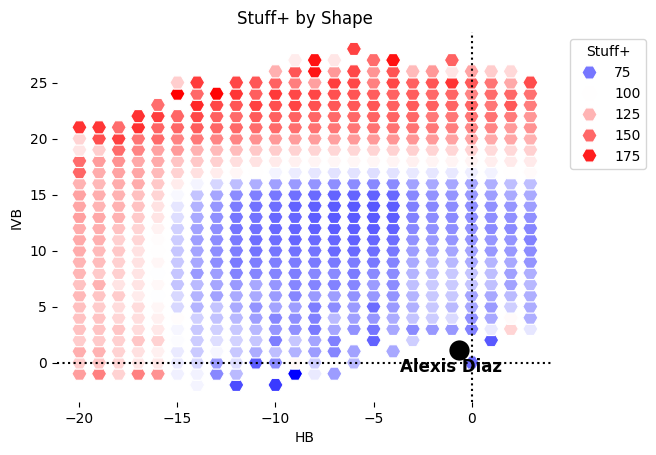

In [102]:
# plot the heatmap
norm = mcolors.TwoSlopeNorm(vcenter=100)

sns.scatterplot(data=velo_sd.loc[(velo_sd['pfx_x_adj'].between(-20,3)) & (velo_sd['pfx_z'].between(-2,28))], x='pfx_x_adj', y='pfx_z',
                hue='stuff+ Fastball', palette='bwr', marker='H', s=120, hue_norm=norm)
sns.scatterplot(data = diaz, x='pfx_x_adj', y='pfx_z', color = 'k', s=250)
plt.text(x = float(diaz['pfx_x_adj']) - 3, y = float(diaz['pfx_z']) - 2, s = 'Alexis Diaz', size = 12, weight='bold')
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Stuff+')
plt.title('Stuff+ by Shape')
plt.xlabel('HB')
plt.ylabel('IVB')
plt.axhline(0, c='k', ls=':')
plt.axvline(0, c='k', ls=':')
sns.despine(left = True, bottom = True)
plt.show()

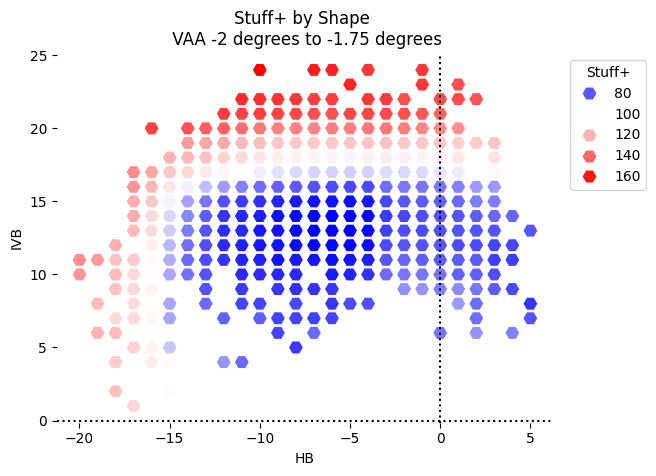

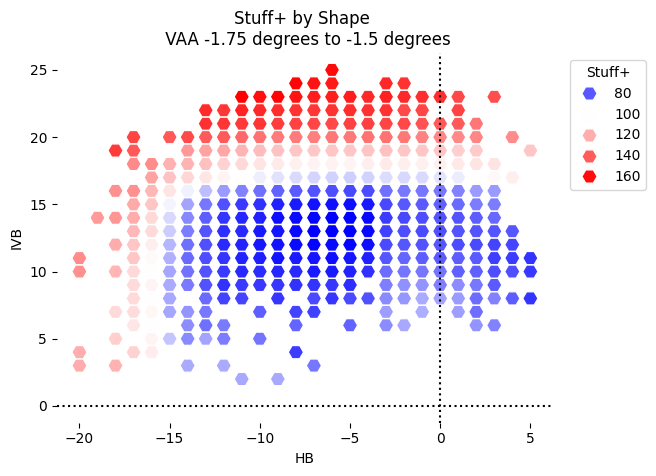

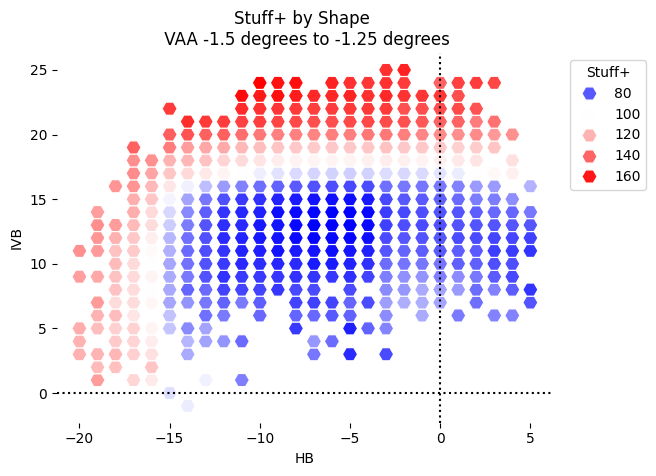

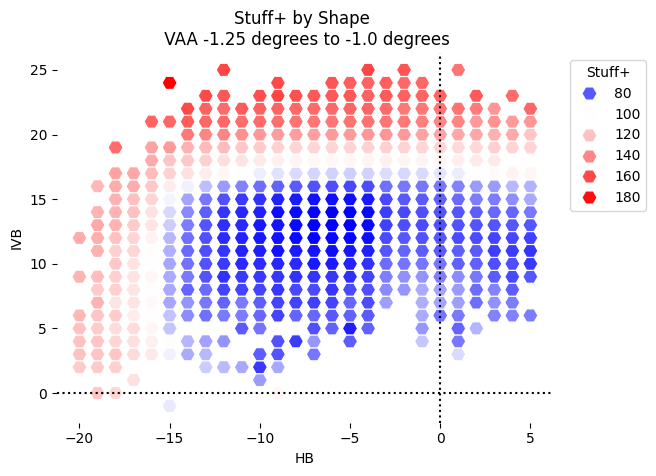

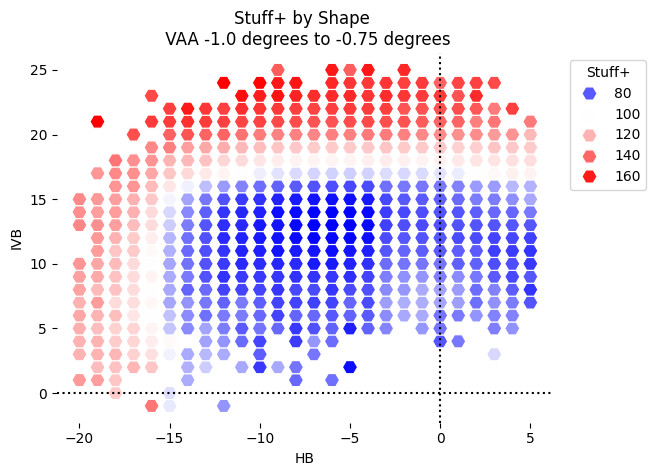

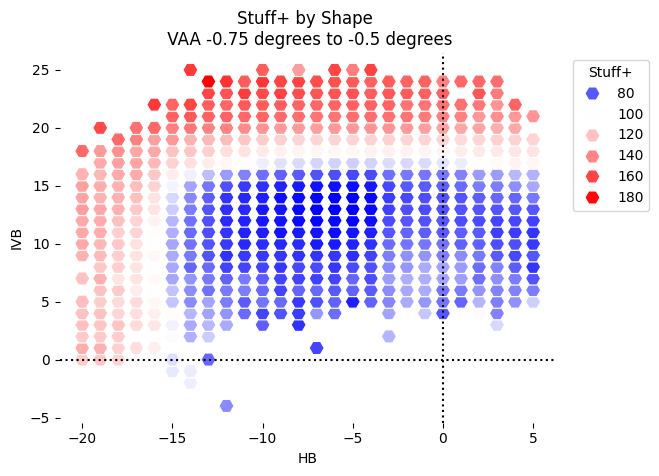

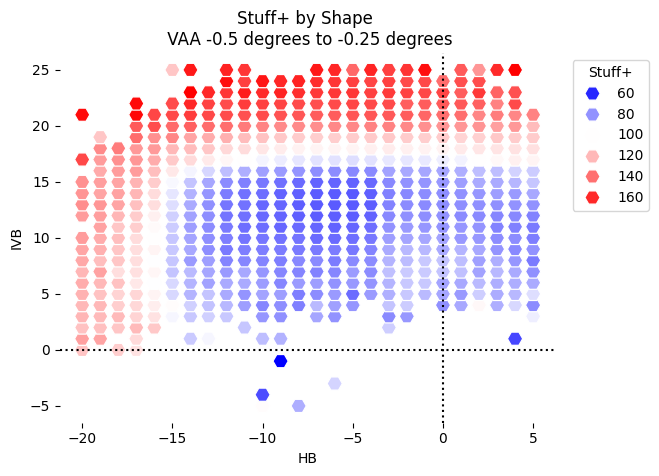

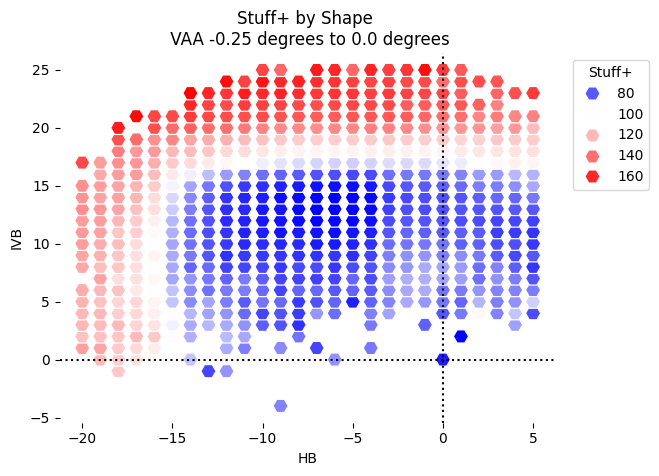

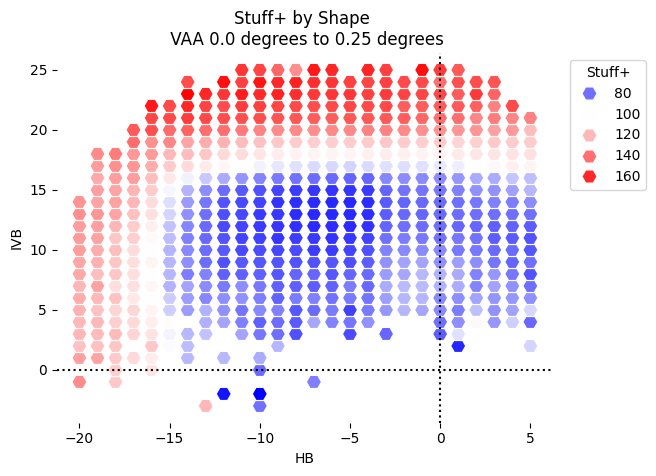

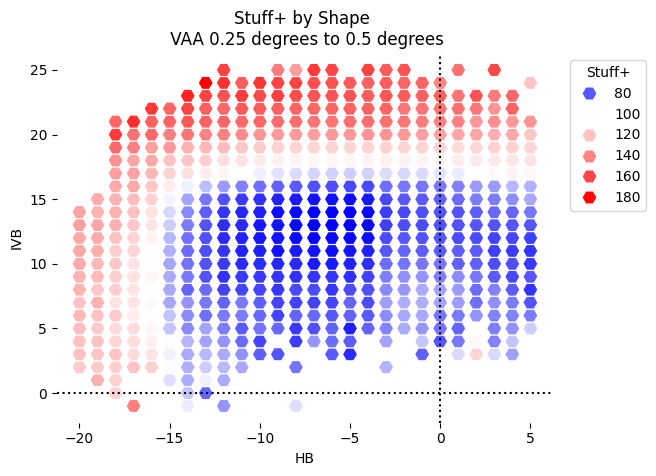

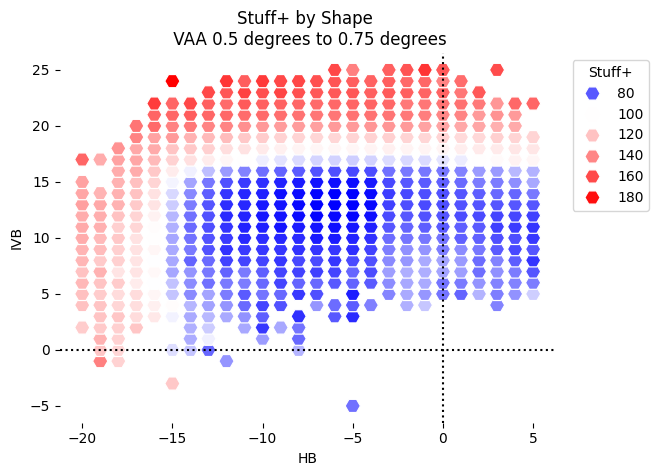

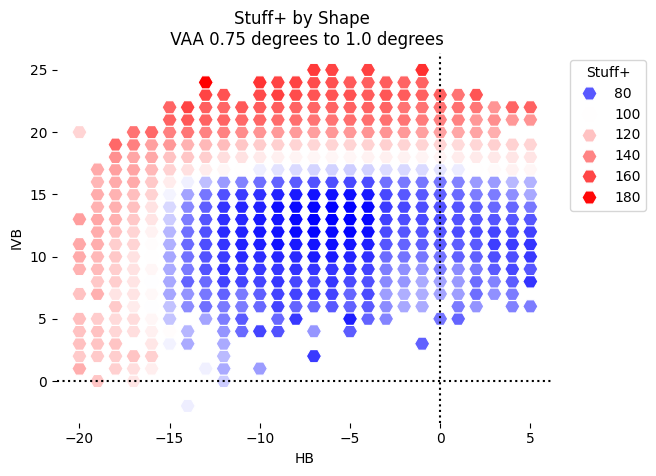

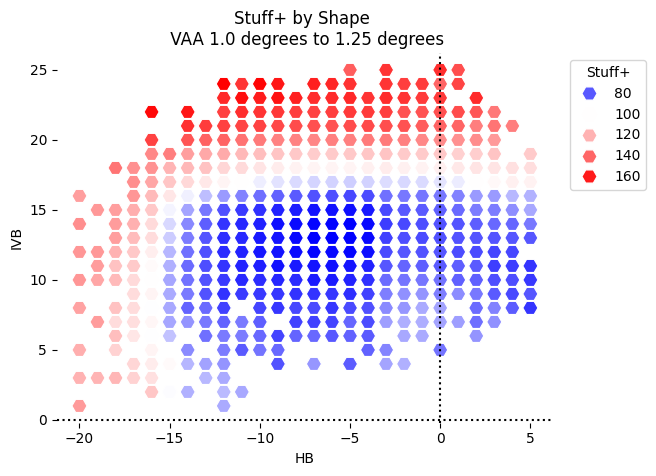

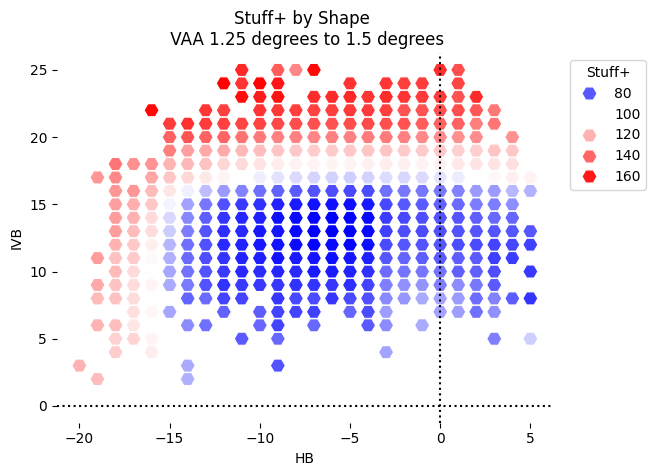

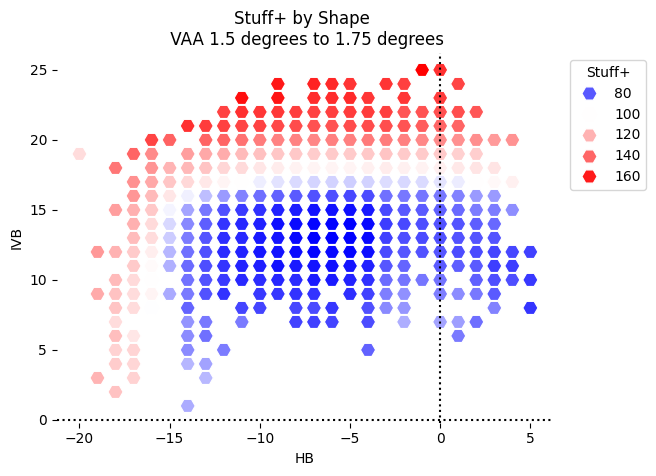

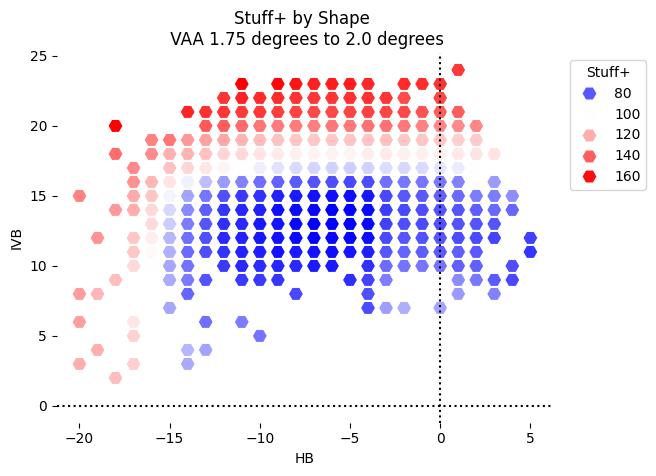

In [103]:
#stuff by shape and adjusted VAA
start = -2
while start < 2:
  end = start + 0.25

  #filter for fastballs
  velo_sd_vaa = model_df[['pfx_z', 'pfx_x_adj','stuff+ Fastball']].loc[(model_df['pitch_type'] == 'FF') & (model_df['release_speed'] >= 89.900 - 5.960) & (model_df['release_speed'] <= 89.900 + 5.960) & model_df['vaaa'].between(start,end)].copy()

  #center the gradient of plot at 100
  norm = mcolors.TwoSlopeNorm(vcenter=100)

  #convert movement to inches and round each inch to aggregate stuff
  for col in ['pfx_z', 'pfx_x_adj']:
    velo_sd_vaa[col] = velo_sd_vaa[col].mul(12)
    velo_sd_vaa[col] = round(velo_sd_vaa[col])

  # get an avg stuff rating for each interval of ivb and hz
  velo_sd_vaa = velo_sd_vaa.groupby(['pfx_z', 'pfx_x_adj'], as_index=False).mean()

  #pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
  matrix_velo_sd_vaa = pd.pivot_table(velo_sd_vaa, values='stuff+ Fastball', index='pfx_z', columns='pfx_x_adj')
  #fill all empty cells with 0 as they will have 0 % whiff rate in plot
  matrix_velo_sd_vaa = matrix_velo_sd_vaa.fillna(0)
  #transform the array back into df
  heatmap_temp_velo_sd_vaa = pd.DataFrame(matrix_velo_sd_vaa, index=matrix_velo_sd_vaa.index, columns=matrix_velo_sd_vaa.columns)
  heatmap_temp_velo_sd_vaa = heatmap_temp_velo_sd_vaa.reset_index()
  #melt columns from wide to long
  df_temp_velo_sd = pd.melt(heatmap_temp_velo_sd, id_vars='pfx_z', value_name='stuff+ Fastball')
  #merge values back to original df
  velo_sd = df_temp_velo_sd.merge(velo_sd_vaa.loc[:, ['pfx_z', 'pfx_x_adj']])


  # plot the heatmap
  sns.scatterplot(data=velo_sd.loc[(velo_sd['pfx_x_adj'].between(-20,5)) & (velo_sd['pfx_z'].between(-5,25))], x='pfx_x_adj', y='pfx_z',
                  hue='stuff+ Fastball', palette='bwr', marker='H', s=120, hue_norm=norm)
  plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Stuff+')
  plt.title('Stuff+ by Shape \n VAA {} degrees to {} degrees'.format(start,end))
  plt.xlabel('HB')
  plt.ylabel('IVB')
  plt.axhline(0, c='k', ls=':')
  plt.axvline(0, c='k', ls=':')
  sns.despine(left = True, bottom = True)
  plt.show()

  start = start + 0.25


88


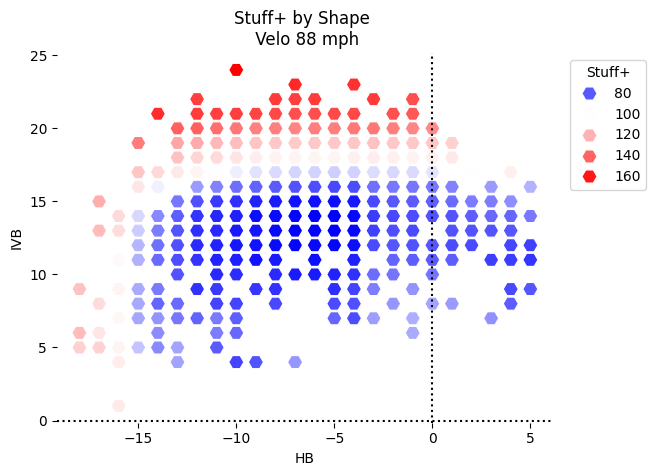

89


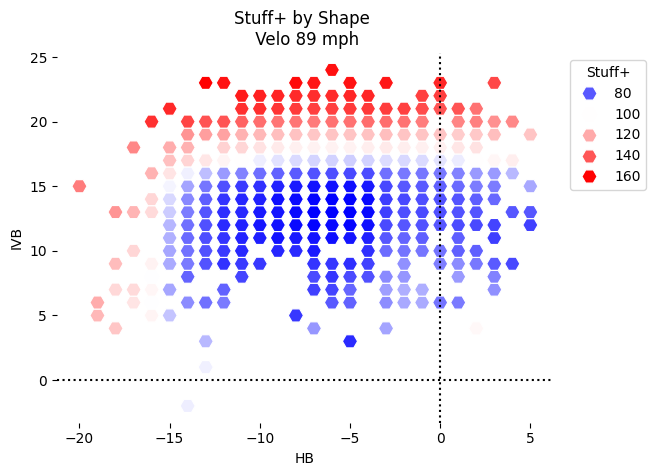

90


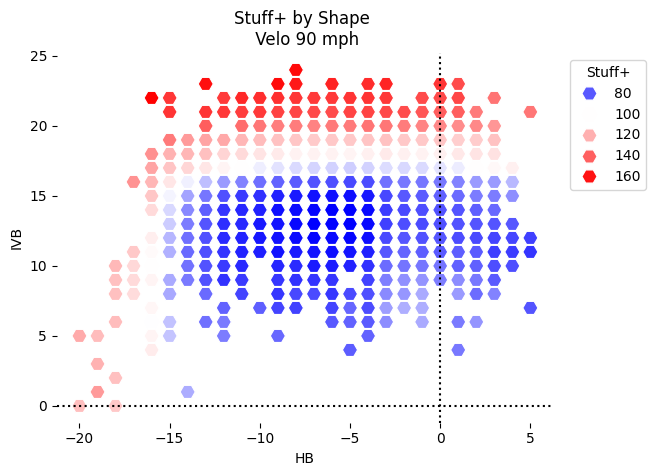

91


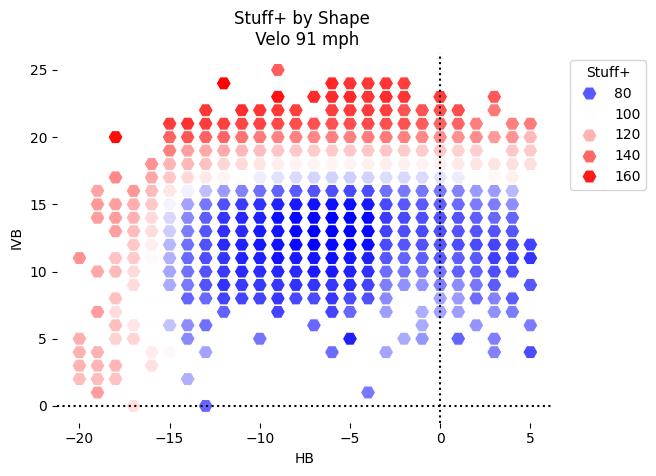

92


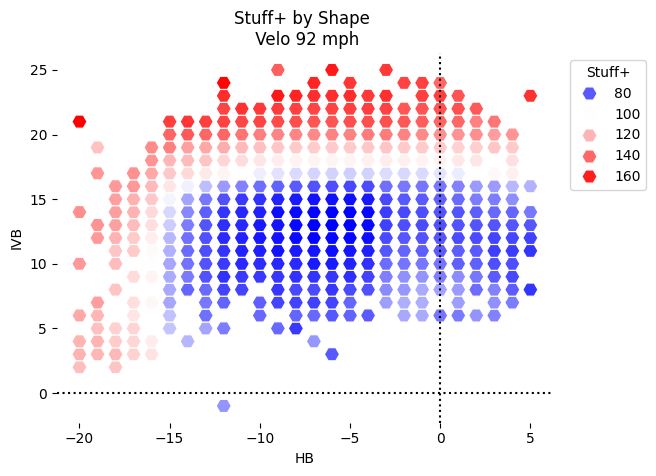

93


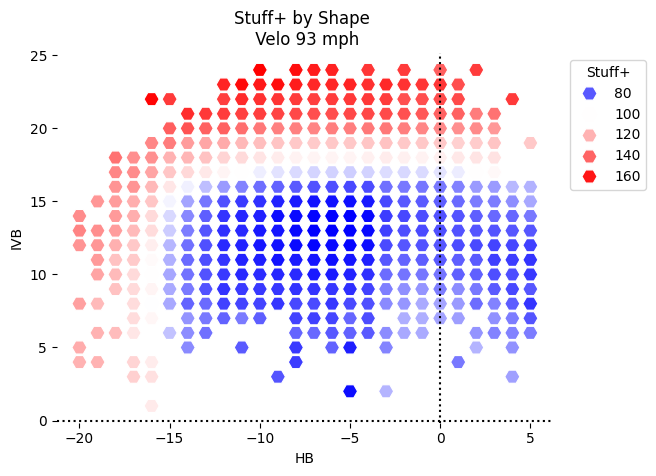

94


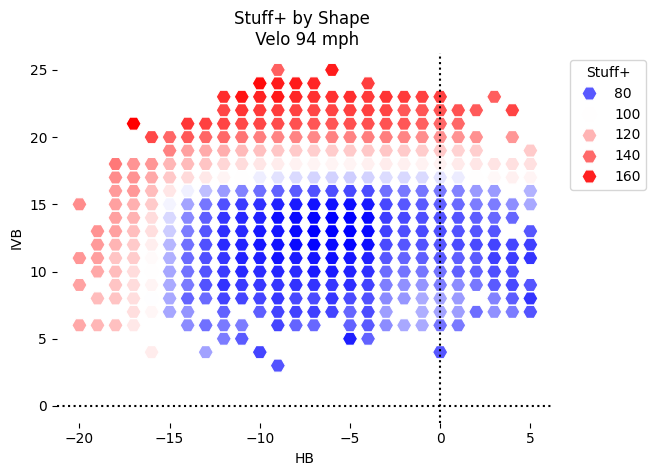

95


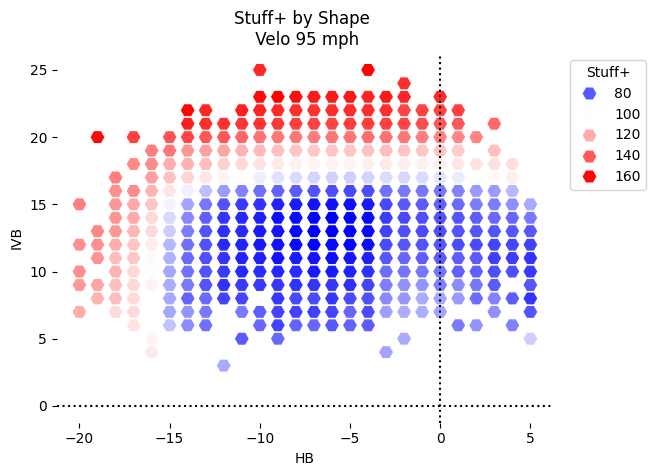

96


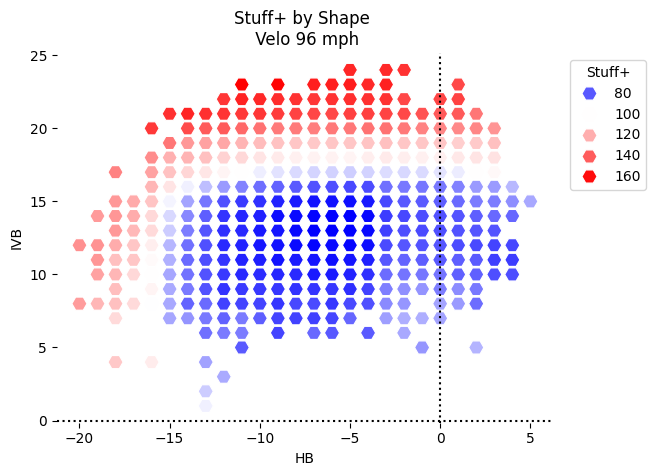

97


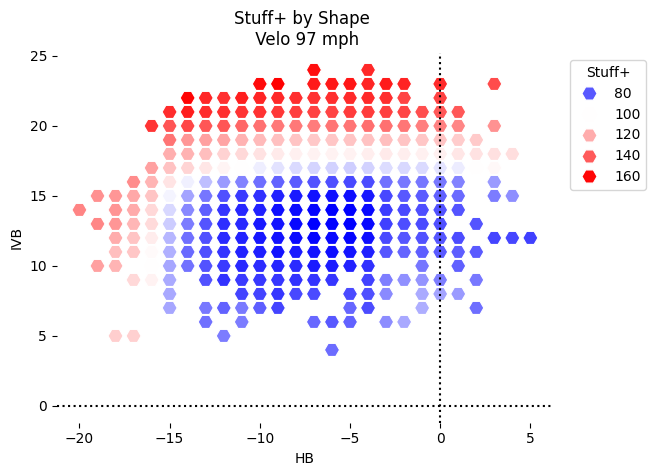

98


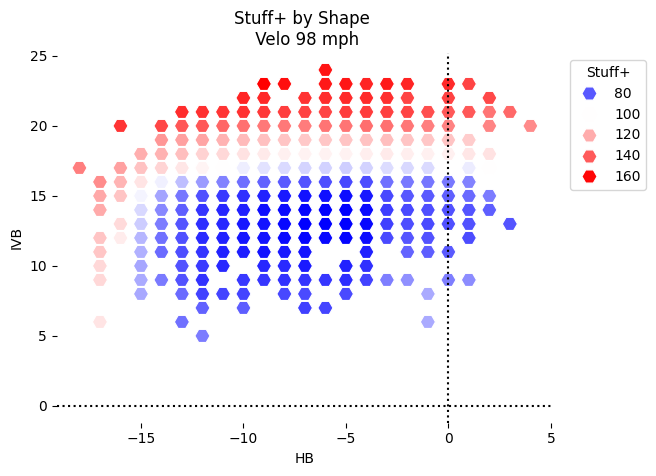

99


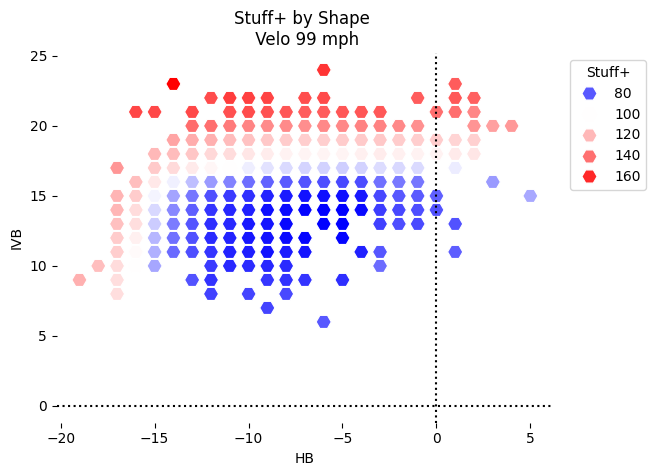

100


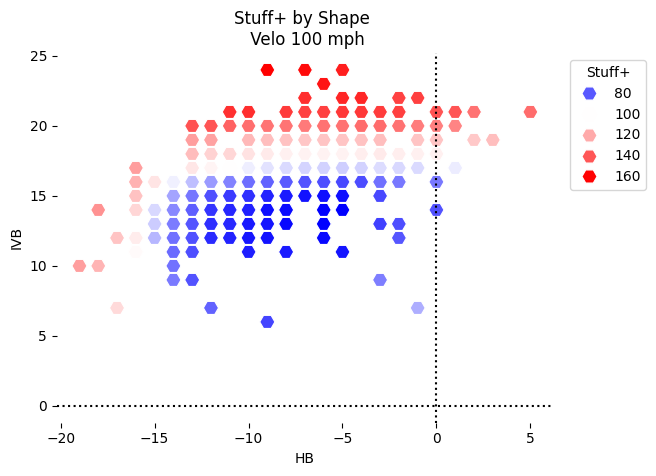

101


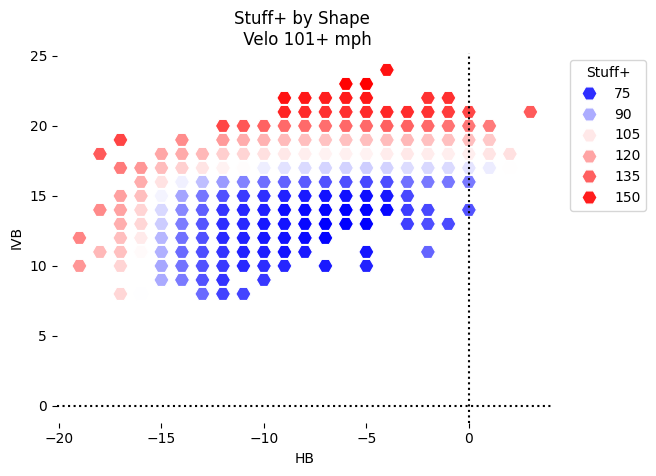

In [104]:
#stuff by shape and velocity for fastballs

for velo in range(88,102):
  print(velo)
  if velo < 101:
    #filter for fastballs
    velo_sd_vaa = model_df[['pfx_z', 'pfx_x_adj','stuff+ Fastball']].loc[(model_df['pitch_type'] == 'FF') & (model_df['release_speed'] == velo)].copy()

    #center the gradient of plot at 100
    norm = mcolors.TwoSlopeNorm(vcenter=100)

    #convert movement to inches and round each inch to aggregate stuff
    for col in ['pfx_z', 'pfx_x_adj']:
      velo_sd_vaa[col] = velo_sd_vaa[col].mul(12)
      velo_sd_vaa[col] = round(velo_sd_vaa[col])

    # get an avg stuff rating for each interval of ivb and hz
    velo_sd_vaa = velo_sd_vaa.groupby(['pfx_z', 'pfx_x_adj'], as_index=False).mean()

    #pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
    matrix_velo_sd_vaa = pd.pivot_table(velo_sd_vaa, values='stuff+ Fastball', index='pfx_z', columns='pfx_x_adj')
    #fill all empty cells with 0 as they will have 0 % whiff rate in plot
    matrix_velo_sd_vaa = matrix_velo_sd_vaa.fillna(0)
    #transform the array back into df
    heatmap_temp_velo_sd_vaa = pd.DataFrame(matrix_velo_sd_vaa, index=matrix_velo_sd_vaa.index, columns=matrix_velo_sd_vaa.columns)
    heatmap_temp_velo_sd_vaa = heatmap_temp_velo_sd_vaa.reset_index()
    #melt columns from wide to long
    df_temp_velo_sd = pd.melt(heatmap_temp_velo_sd, id_vars='pfx_z', value_name='stuff+ Fastball')
    #merge values back to original df
    velo_sd = df_temp_velo_sd.merge(velo_sd_vaa.loc[:, ['pfx_z', 'pfx_x_adj']])


    # plot the heatmap
    sns.scatterplot(data=velo_sd.loc[(velo_sd['pfx_x_adj'].between(-20,5)) & (velo_sd['pfx_z'].between(-5,25))], x='pfx_x_adj', y='pfx_z',
                    hue='stuff+ Fastball', palette='bwr', marker='H', s=120, hue_norm=norm)
    plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Stuff+')
    plt.title('Stuff+ by Shape \n Velo {} mph'.format(velo))
    plt.xlabel('HB')
    plt.ylabel('IVB')
    plt.axhline(0, c='k', ls=':')
    plt.axvline(0, c='k', ls=':')
    sns.despine(left = True, bottom = True)
    plt.show()

  else:
        #filter for fastballs
    velo_sd_vaa = model_df[['pfx_z', 'pfx_x_adj','stuff+ Fastball']].loc[(model_df['pitch_type'] == 'FF') & (model_df['release_speed'] >= velo)].copy()

    #center the gradient of plot at 100
    norm = mcolors.TwoSlopeNorm(vcenter=100)

    #convert movement to inches and round each inch to aggregate stuff
    for col in ['pfx_z', 'pfx_x_adj']:
      velo_sd_vaa[col] = velo_sd_vaa[col].mul(12)
      velo_sd_vaa[col] = round(velo_sd_vaa[col])

    # get an avg stuff rating for each interval of ivb and hz
    velo_sd_vaa = velo_sd_vaa.groupby(['pfx_z', 'pfx_x_adj'], as_index=False).mean()

    #pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
    matrix_velo_sd_vaa = pd.pivot_table(velo_sd_vaa, values='stuff+ Fastball', index='pfx_z', columns='pfx_x_adj')
    #fill all empty cells with 0 as they will have 0 % whiff rate in plot
    matrix_velo_sd_vaa = matrix_velo_sd_vaa.fillna(0)
    #transform the array back into df
    heatmap_temp_velo_sd_vaa = pd.DataFrame(matrix_velo_sd_vaa, index=matrix_velo_sd_vaa.index, columns=matrix_velo_sd_vaa.columns)
    heatmap_temp_velo_sd_vaa = heatmap_temp_velo_sd_vaa.reset_index()
    #melt columns from wide to long
    df_temp_velo_sd = pd.melt(heatmap_temp_velo_sd, id_vars='pfx_z', value_name='stuff+ Fastball')
    #merge values back to original df
    velo_sd = df_temp_velo_sd.merge(velo_sd_vaa.loc[:, ['pfx_z', 'pfx_x_adj']])


    # plot the heatmap
    sns.scatterplot(data=velo_sd.loc[(velo_sd['pfx_x_adj'].between(-20,5)) & (velo_sd['pfx_z'].between(-5,25))], x='pfx_x_adj', y='pfx_z',
                    hue='stuff+ Fastball', palette='bwr', marker='H', s=120, hue_norm=norm)
    plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Stuff+')
    plt.title('Stuff+ by Shape \n Velo {}+ mph'.format(velo))
    plt.xlabel('HB')
    plt.ylabel('IVB')
    plt.axhline(0, c='k', ls=':')
    plt.axvline(0, c='k', ls=':')
    sns.despine(left = True, bottom = True)
    plt.show()


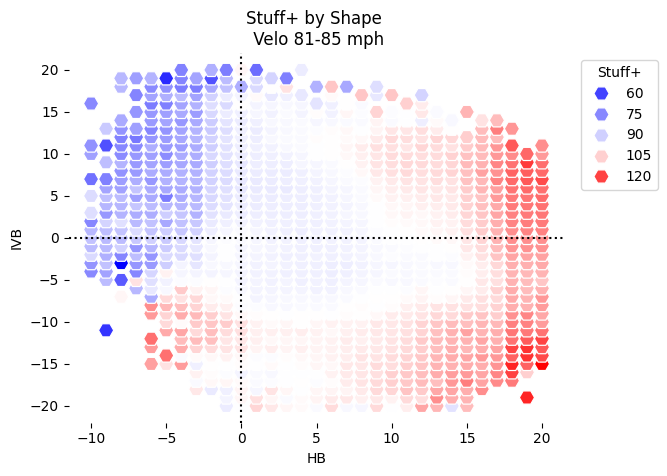

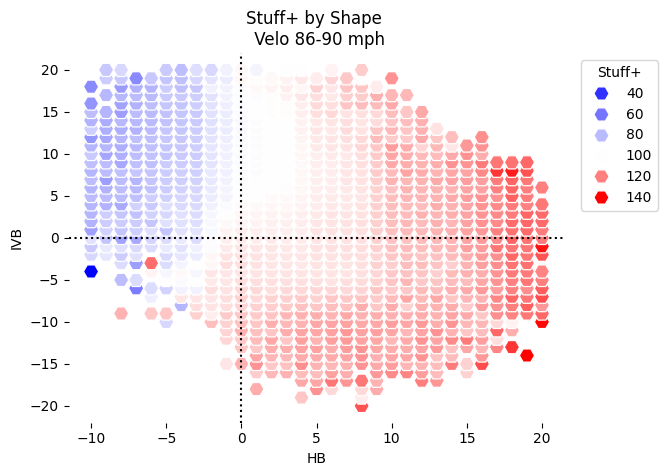

In [106]:
#slow breaking balls vs fast breaking balls stuff by shape plots
velo_bb = model_df[['pfx_z', 'pfx_x_adj','stuff+']].loc[model_df['pitch_family'].isin(['Slider','Curveball']) & (model_df['release_speed'].between(81,85))].copy()

#center the gradient of plot at 100
norm = mcolors.TwoSlopeNorm(vcenter=100)

#convert movement to inches and round each inch to aggregate stuff
for col in ['pfx_z', 'pfx_x_adj']:
  velo_bb[col] = velo_bb[col].mul(12)
  velo_bb[col] = round(velo_bb[col])

# get an avg stuff rating for each interval of ivb and hz
velo_bb = velo_bb.groupby(['pfx_z', 'pfx_x_adj'], as_index=False).mean()

#pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
matrix_velo_bb = pd.pivot_table(velo_bb, values='stuff+', index='pfx_z', columns='pfx_x_adj')
#fill all empty cells with 0 as they will have 0 % whiff rate in plot
matrix_velo_bb = matrix_velo_bb.fillna(0)
#transform the array back into df
heatmap_temp_velo_bb = pd.DataFrame(matrix_velo_bb, index=matrix_velo_bb.index, columns=matrix_velo_bb.columns)
heatmap_temp_velo_bb = heatmap_temp_velo_bb.reset_index()
#melt columns from wide to long
df_temp_velo_bb = pd.melt(heatmap_temp_velo_bb, id_vars='pfx_z', value_name='stuff+')
#merge values back to original df
velo_bb = df_temp_velo_bb.merge(velo_bb.loc[:, ['pfx_z', 'pfx_x_adj']])


# plot the heatmap
sns.scatterplot(data=velo_bb.loc[(velo_bb['pfx_x_adj'].between(-10,20)) & (velo_bb['pfx_z'].between(-20,20))], x='pfx_x_adj', y='pfx_z',
                hue='stuff+', palette='bwr', marker='H', s=120, hue_norm=norm)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Stuff+')
plt.title('Stuff+ by Shape \n Velo 81-85 mph')
plt.xlabel('HB')
plt.ylabel('IVB')
plt.axhline(0, c='k', ls=':')
plt.axvline(0, c='k', ls=':')
sns.despine(left = True, bottom = True)
plt.show()

#fast breaking balls
#slow breaking balls vs fast breaking balls stuff by shape plots
velo_bb = model_df[['pfx_z', 'pfx_x_adj','stuff+']].loc[model_df['pitch_family'].isin(['Slider','Curveball']) & (model_df['release_speed'].between(86,90))].copy()

#center the gradient of plot at 100
norm = mcolors.TwoSlopeNorm(vcenter=100)

#convert movement to inches and round each inch to aggregate stuff
for col in ['pfx_z', 'pfx_x_adj']:
  velo_bb[col] = velo_bb[col].mul(12)
  velo_bb[col] = round(velo_bb[col])

# get an avg stuff rating for each interval of ivb and hz
velo_bb = velo_bb.groupby(['pfx_z', 'pfx_x_adj'], as_index=False).mean()

#pivot the heatmap by pfx_x_adj to get a matrix representing the density for each point on the plot
matrix_velo_bb = pd.pivot_table(velo_bb, values='stuff+', index='pfx_z', columns='pfx_x_adj')
#fill all empty cells with 0 as they will have 0 % whiff rate in plot
matrix_velo_bb = matrix_velo_bb.fillna(0)
#transform the array back into df
heatmap_temp_velo_bb = pd.DataFrame(matrix_velo_bb, index=matrix_velo_bb.index, columns=matrix_velo_bb.columns)
heatmap_temp_velo_bb = heatmap_temp_velo_bb.reset_index()
#melt columns from wide to long
df_temp_velo_bb = pd.melt(heatmap_temp_velo_bb, id_vars='pfx_z', value_name='stuff+')
#merge values back to original df
velo_bb = df_temp_velo_bb.merge(velo_bb.loc[:, ['pfx_z', 'pfx_x_adj']])


# plot the heatmap
sns.scatterplot(data=velo_bb.loc[(velo_bb['pfx_x_adj'].between(-10,20)) & (velo_bb['pfx_z'].between(-20,20))], x='pfx_x_adj', y='pfx_z',
                hue='stuff+', palette='bwr', marker='H', s=120, hue_norm=norm)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, title='Stuff+')
plt.title('Stuff+ by Shape \n Velo 86-90 mph')
plt.xlabel('HB')
plt.ylabel('IVB')
plt.axhline(0, c='k', ls=':')
plt.axvline(0, c='k', ls=':')
sns.despine(left = True, bottom = True)
plt.show()


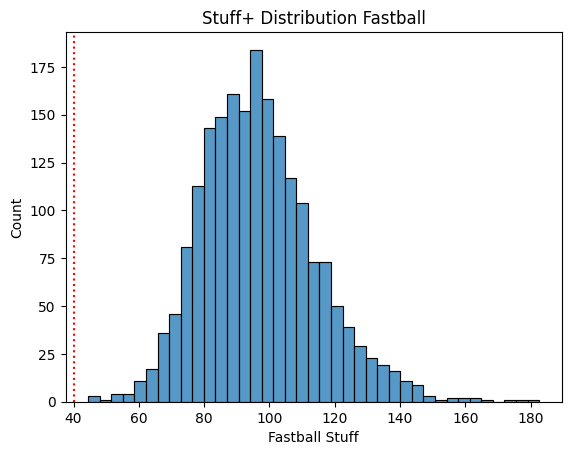

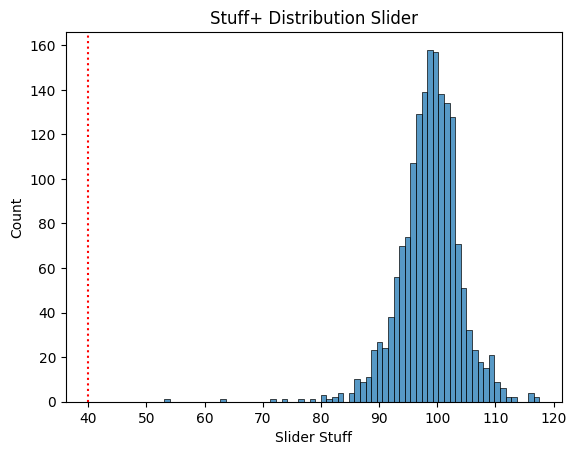

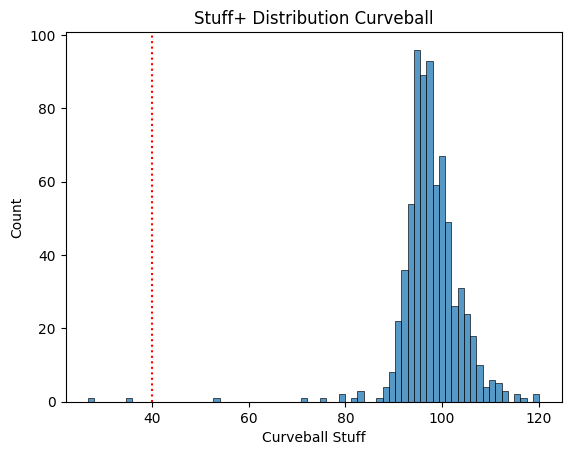

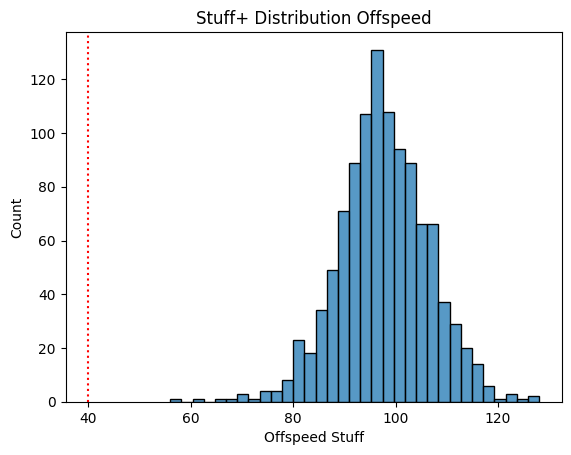

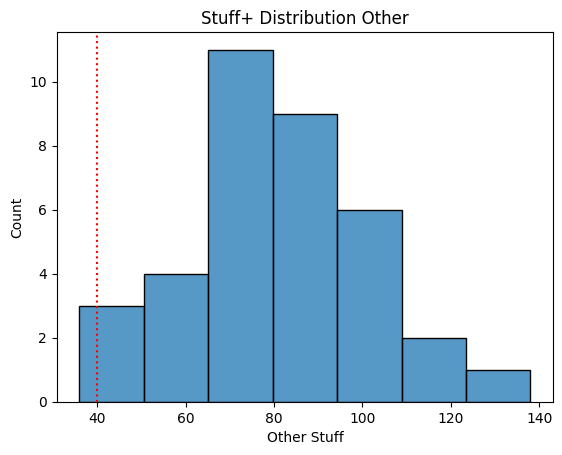

In [156]:
model_df_agg = model_df[['pitcher','pitcher_name','pitch_name','pitch_type','pitch_family','stuff+']].groupby(['pitcher','pitcher_name','pitch_name','pitch_type','pitch_family'], as_index = False).mean()
_model_df_agg = model_df[['pitcher','pitcher_name','pitch_name','pitch_type','pitch_family','stuff+']].groupby(['pitcher','pitcher_name','pitch_name','pitch_type','pitch_family'], as_index = False).count().rename(columns = {'stuff+':'count'})
model_df_agg = model_df_agg.merge(_model_df_agg)

#get an idea of how many times the pitch has been thrown by a different pitcher
for p_type in pitch_family_types:
  sns.histplot(model_df_agg['stuff+'].loc[model_df_agg['pitch_family'] == p_type])
  plt.title('Stuff+ Distribution {}'.format(p_type))
  plt.xlabel('{} Stuff'.format(p_type))
  plt.ylabel('Count')
  plt.axvline(40, ls = ':', c = 'r')
  plt.show()



In [161]:
#top 25 leaderboards for each pitch type all time
for p_type in pitch_family_types:
  print(model_df_agg.loc[(model_df_agg['pitch_family'] == p_type) & (model_df_agg['count'] >= 40)].sort_values(by = 'stuff+', ascending = False).head(25))


      pitcher        pitcher_name       pitch_name pitch_type pitch_family  \
2813   642585     Bautista, Félix  4-Seam Fastball         FF     Fastball   
3865   664126     Fairbanks, Pete  4-Seam Fastball         FF     Fastball   
788    545333       Bauer, Trevor  4-Seam Fastball         FF     Fastball   
4316   669093   Estrada, Jeremiah  4-Seam Fastball         FF     Fastball   
553    521230      Hendriks, Liam  4-Seam Fastball         FF     Fastball   
831    547973    Chapman, Aroldis           Sinker         SI     Fastball   
167    456713          Bush, Matt  4-Seam Fastball         FF     Fastball   
5229   681911         Vesia, Alex  4-Seam Fastball         FF     Fastball   
4591   670183      Acton, Garrett  4-Seam Fastball         FF     Fastball   
5470   691587         Pérez, Eury  4-Seam Fastball         FF     Fastball   
4552   670056      Baragar, Caleb  4-Seam Fastball         FF     Fastball   
1684   605483        Snell, Blake  4-Seam Fastball         FF   

It appears my model is able to rate a pitch pretty well when looking at shape and speed. Dead zone pitches fall right around average or a little below. Pitches on the outside tend to perform better or worse than average depending on location, movement, other factors. When looking at the distribution, there is a much larger squeeze toward average (100) than when viewing public models like Driveline's. I think cleaning up the data further and really hammering down on what defines a competitve pitch will result in a more disperse ratings.



A side note before moving forward, I mirrored left handed movements to match right handed players which would appear inverted when looking at other models. These features would include release position, pitchfx, and horizontal approach angles.



Next steps with this project:
- model 2024 data and compare to other public models
- clean up data even further to feed better input data into my model
- add a location model by adding in the plate location into the stuff model and using the differences in expected run value as the added knowledge of location
- trying a model without adjusted horizontal approach angle and adjusted vertical approach angle. These two features give the initial model insight into how the pitch approaching as the pitch crosses home plate. Since a stuff model is designed to estimate a rating for each pitch based on movement alone, I feel that approach angles may give too much insight for the model.



Changes I made from my original stuff model include:
- the switch from R to Python  
- additional features added
- model choice from random forest to xgb
- parameter tuning
- switching target from whiff pct to xRV

These choices were made for not only convience and time, but also for improvements to the project. `Baseballr` can grab the data from statcast, but `pybaseball` is far superior at grabbing years worth of data quicky. The choice to move from R to Python was for the sake of computational power. My inital project was done on R using my own local computer, and every chunck of code I ran made my computer sound like a jet engine was taking off. With the use of google colab I was able to run my model much more effectively. Google colab also gives me the power to mount my google drive and store my files in my google drive. This is useful for reusability when I initially load the data and save it to my drive for future additions to this notebook. Google drive will also open up usability for others who view this notebook as my older project had everything stored locally. The choice to add additional features comes from the extensive research I have done in the past year. Watching Nick Wan build his model and reading articles from Driveline and Fangraphs inspired me to take another crack at a better model. My choice to use random forest originally over xgboost was for the fact of the model learning too much. I was concerned that when using a gradient boosted model, my model would learn to favor a way a pitcher throws rather than the value that pitch provides. Say for example, Felix Bautista's fastball. My original model favored his fastball because it induced a lot of swings and misses. This is promising that my model could pick up on a pitch with a good whiff percentage, but it left me wondering if the way he throws that is causing this uptick in stuff rather than everything about pitch from release to the way it moves. The switch to xgboost was to utilize the increased performance a model can receive from applying gradient boosting. Allowing the model to learn from previous iterations of itself could be a positive or negative impact. If the model learns too much, the model could be subject to overfitting to the training set. I believe that xgboost will not overfit in this scenario as the model utilizes over 1.5 million training points and roughly half a million testing pitches. This model also uses a cross fold technique that allows for reuse of the data across multiple training and test sets so long as the pitch has not been seen before in the test set. Cross folding makes me more confident that this model is better trained as it has seen more data than a traditional 80/20 split. The last point I want to touch on is the switch from target variables from whiff percentage to expected run value. In my original model, I used whiff percentage, however that was not always the case. I tried a model with expected run value, but I was not satisfied with the results. I had too few features and the model was far less accurate at projecting expected run value at the pitch level. Almost every pitch had the same projected run value which makes sense being that a small percentage of balls are not just balls and strikes. I felt whiff percentage made a better target feature in my initial model because of the model's ability to discern a pitch that invoked a lot of whiffs. Now with my addition of new features in the new model, I am more comfortable going back to expected run value. I feel expected run value makes for a better target feature as that can translate to many other models as well. WAR for example can be classified as between 9 and 10 runs saved is 1 win. Having expected run value as a feature now allows me to translate my expected run value to different areas of baseball. Not to mention almost every article I read uses expected run value as their target feature. With all these changes made, I am happy with my new model, but not satisfied. I believe I could improve further that what has been done in this notebook.
